# Project Part II: Predicting Housing Prices - Build Your Own Model

 

### Grading Scheme

Your grade for the project will be based on your training RMSE and test RMSE. The thresholds are as follows:

Points | 9 | 7 | 5 | 3
--- | --- | --- | --- | ---
Training RMSE | Less than 60k | [60k, 120k) | [120k, 200k) | More than 230k

Points | 9 | 7 | 5 | 3
--- | --- | --- | --- | ---
Test RMSE | Less than 65k | [65k, 130k) | [130k, 230k) | More than 230k

The top 20% of the submissions with the least testing errors will receive the additional two points


In [1]:
# Some Imports You Might Need
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model as lm

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# Extract Dataset
with zipfile.ZipFile('cook_county_contest_data.zip') as item:
    item.extractall()
    
    
### Note: we filtered the data in cook_county_contest_data, 
####so please use this dataset instead of the old one.

### Note

This notebook is specifically designed to guide you through the process of exporting your model's predictions on the test dataset for submission so you can see how your model performs.

Most of what you have done in project part I should be transferrable here. 

## Step 1. Set up all the helper functions for your `process_data_fm` function.

**Copy-paste all of the helper functions your `process_data_fm` need here in the following cell**. You **do not** have to fill out all of the functions in the cell below -- only fill out those that are actually useful to your feature engineering pipeline.

In [50]:
from sklearn.preprocessing import OneHotEncoder


def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] >= lower) & (data[variable] <= upper)] # Note that we need () to enclose the conditions

# Add 2 new columns, we define the add log function, we have no arguments here
def add_log_info(data):
    '''
    input: data as dataframe
    output: updated data, with two log infomation added
    '''
    data['Log Building Square Feet'] = np.log(data['Building Square Feet']) # Build a new Log Building Square Feet
    return data

def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    pattern = r"rooms, (\d)"
    bedroom_list = with_rooms['Description'].str.findall(pattern).map(lambda x: int(x[0]) if len(x) == 1 else 0)
    with_rooms['Bedrooms'] = bedroom_list
    return with_rooms

def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    pattern = r", and (\d)"
    bathroom_list = with_rooms['Description'].str.findall(pattern).map(lambda x: int(x[0]) if len(x) == 1 else 0)
    with_rooms['Bathrooms'] = bathroom_list
    return with_rooms

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form 0x_QUALITY.
    """
    enc = OneHotEncoder(handle_unknown = 'ignore')
    # print(data)
    arr = enc.fit_transform(data[['Roof Material']]).toarray() # Return a two dimensional array we need
    print(enc.categories_) # Print this so that we can interpret the array correctly 
    arr_df = pd.DataFrame(arr, index = data.index, columns = enc.get_feature_names()) # Construct a df to join
    # print(arr_df)
    arr_df.columns = arr_df.columns.map(lambda x: 'roof' + x)
    data = pd.concat([data, arr_df], axis = 1)
    return data
    
def process_data_gm(data, pipeline_functions):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    return data

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]



# This makes the train-test split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_test_split in general

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_test_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    cut_at = int(len(data) * 0.8) # we define the cut point, round to the closet integer of 0.8 of the total length
    train_indices = shuffled_indices[0: cut_at]
    test_indices = shuffled_indices[cut_at:]
    train = data.iloc[train_indices] # Use iloc and a list of indices to split the dataframe
    test = data.iloc[test_indices]
    return train, test

def ohe_town_code(data):
    enc = OneHotEncoder(handle_unknown = 'ignore')
    arr = enc.fit_transform(data[['Town Code']]).toarray() # Return a two dimensional array we need
    arr_df = pd.DataFrame(arr, index = data.index, columns = enc.get_feature_names())# Construct a df to join
    arr_df.columns = arr_df.columns.map(lambda x: 'town' + x)
    data = pd.concat([data, arr_df], axis = 1)
    return data

def ohe_neighborhood_code(data):
    enc = OneHotEncoder(handle_unknown = 'ignore')
    arr = enc.fit_transform(data[['Neighborhood Code']]).toarray() # Return a two dimensional array we need
    arr_df = pd.DataFrame(arr, index = data.index, columns = enc.get_feature_names())# Construct a df to join
    arr_df.columns = arr_df.columns.map(lambda x: 'neighborhood' + x)
    data = pd.concat([data, arr_df], axis = 1)
    return data

def ohe_garage_material(data):
    enc = OneHotEncoder(handle_unknown = 'ignore')
    arr = enc.fit_transform(data[['Garage 1 Material']]).toarray() # Return a two dimensional array we need
    arr_df = pd.DataFrame(arr, index = data.index, columns = enc.get_feature_names())# Construct a df to join
    arr_df.columns = arr_df.columns.map(lambda x: 'garage' + x)
    data = pd.concat([data, arr_df], axis = 1)
    return data

def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

## Step 2. Setup your `process_data_fm` function

**Create your implementation of `process_data_fm` from into the following cell.**

Here are a few additional things **you should check and change to make sure your `process_data_fm` function satisfies**:
- Unlike part 1, we will not be expecting your `process_data_fm` function to return both the design matrix `X` and the observed target vector `y`; your function should now **only return X**.


In [53]:
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of the function below. 
# Note that data will no longer have the column Sale Price in it directly, so plan your feature engineering process around that.
def process_data_fm(data):
    # Replace the following line with your own feature engineering pipeline
    X = process_data_gm(data,[(add_log_info,None, None), (add_total_bedrooms, None, None), (add_total_bathrooms, None, None), (select_columns,(('Bathrooms','Bedrooms','Log Building Square Feet', 'Age','Basement', 'Central Air', 'Design Plan','Town Code', 'Neighborhood Code', 'Garage 1 Size')), None),(ohe_town_code, None, None), (ohe_neighborhood_code, None, None)])
    return X

## Step 3. Train your model

Run the following cell to import the new set of training data to fit your model on. **You can use any regression model, the following is just an example** If your `process_data_fm` satisfies all the specified requirements, the cell should run without any error.

**As usual**, your model will predict the log-transformed sale price, and our grading will transform your predictions back to the normal vlaues.

#### Linear Regression

In [41]:
train_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
y_train = np.log(train_data['Sale Price'])
train_data = train_data.drop(columns=['Sale Price'])
X_train = process_data_fm(train_data)
model = lm.LinearRegression(fit_intercept=True)
###You can use other models
model.fit(X_train, y_train);

[array([1., 2., 3., 4., 5., 6.])]


In [42]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [43]:
predicted_value = model.predict(X_train)
rmse(np.exp(predicted_value), np.exp(y_train))

94383.29407015938

#### Random Forest

### Do not modify code below

In [55]:
train_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
y_train = np.log(train_data['Sale Price'])
train_data = train_data.drop(columns=['Sale Price'])
X_train = process_data_fm(train_data)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
regr = RandomForestRegressor(random_state=0, n_jobs= -1)
params = {'max_depth':[5,10,15,20,25,30]}
model_finder = GridSearchCV(estimator = regr,
param_grid = params,
scoring = "neg_mean_squared_error",
cv = 5,
verbose=2)
model_finder.fit(X_train, y_train)
print(model_finder.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ........................................max_depth=5; total time=  21.8s
[CV] END ........................................max_depth=5; total time=  21.2s
[CV] END ........................................max_depth=5; total time=  21.9s
[CV] END ........................................max_depth=5; total time=  22.4s
[CV] END ........................................max_depth=5; total time=  21.8s
[CV] END .......................................max_depth=10; total time=  37.5s
[CV] END .......................................max_depth=10; total time=  37.5s
[CV] END .......................................max_depth=10; total time=  37.6s
[CV] END .......................................max_depth=10; total time=  37.1s
[CV] END .......................................max_depth=10; total time=  37.5s
[CV] END .......................................max_depth=15; total time=  47.1s
[CV] END .......................................m

In [56]:
predicted_value_2 = model_finder.predict(X_train)
rmse(np.exp(predicted_value_2), np.exp(y_train))

60398.654768107095

### Run the following code to test on the whole training set

In [54]:
train_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
y_train = np.log(train_data['Sale Price'])
train_data = train_data.drop(columns=['Sale Price'])
X_train = process_data_fm(train_data)
from sklearn.ensemble import RandomForestRegressor
rger_2 = RandomForestRegressor(max_depth = 50, random_state = 0, n_jobs = -1)
rger_2.fit(X_train, y_train)

predicted_value_3 = rger_2.predict(X_train)
print("The training error is: ", rmse(np.exp(predicted_value_3), np.exp(y_train)))

The training error is:  37409.74689083788


### Do not modify code above

Split the data to test the ability of generalization

(9.0, 14.0)

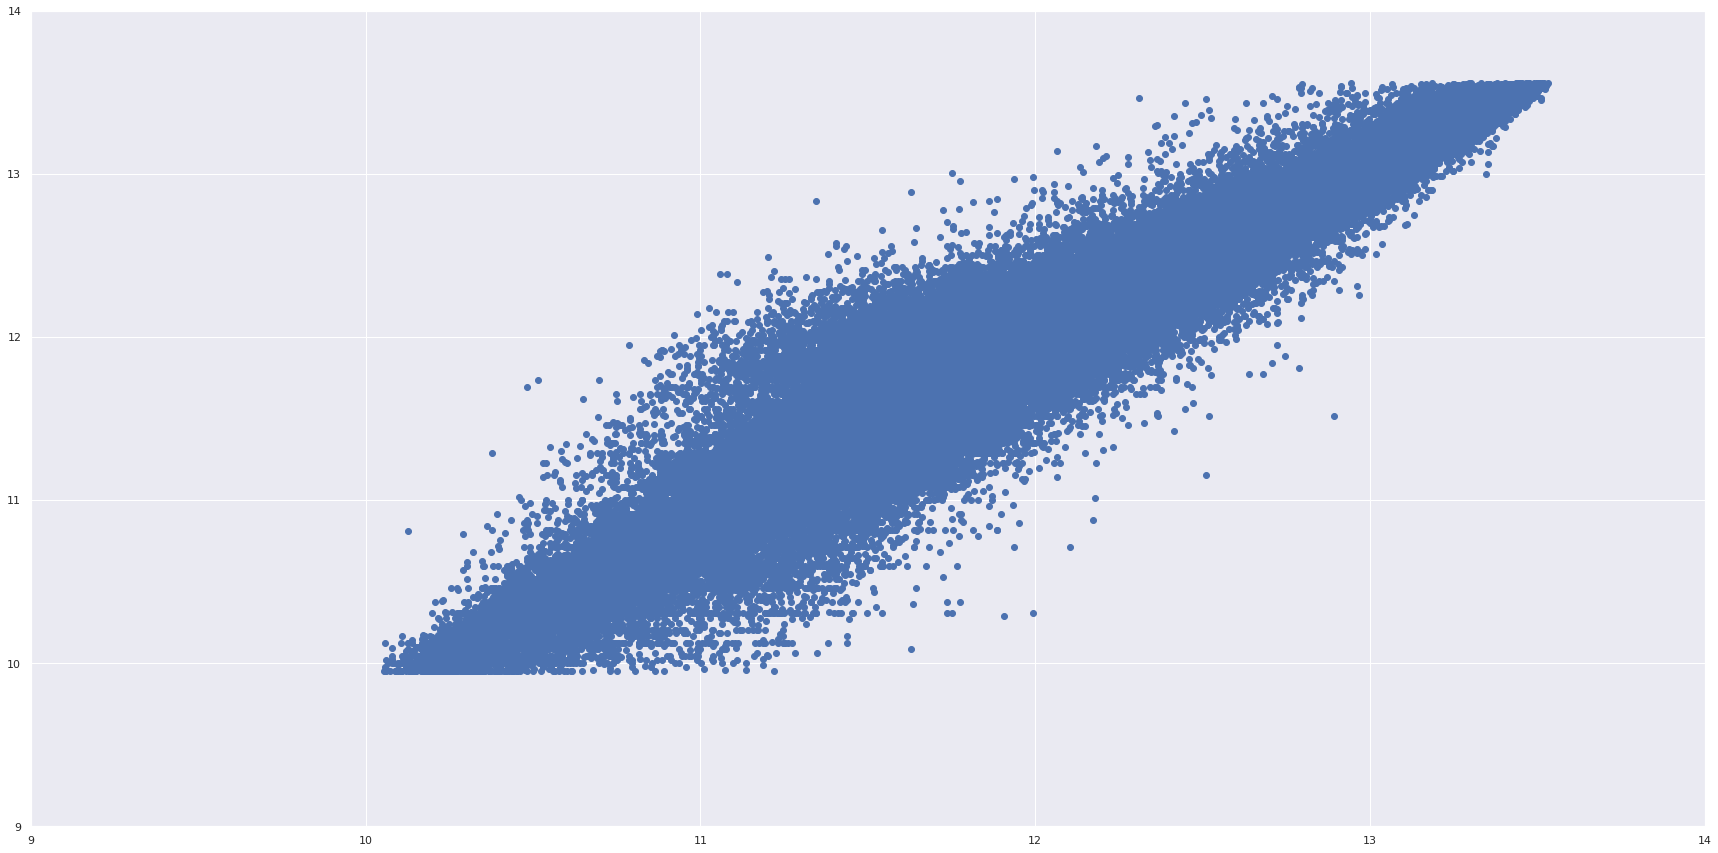

In [63]:
plt.scatter(x = predicted_value_3, y = y_train)
plt.xlim([9,14])
plt.ylim([9,14])

In [46]:
data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
train, test = train_test_split(data)

y_train = np.log(train['Sale Price'])
train = train.drop(columns = ['Sale Price'])
X_train = process_data_fm(train)

y_test = np.log(test['Sale Price'])
test = test.drop(columns = ['Sale Price'])
X_test = process_data_fm(test)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
regr = RandomForestRegressor(random_state=0)
params = {'max_depth':[5,10,15,20,25,30,50,75,100]}
model_finder = GridSearchCV(estimator = regr,
param_grid = params,
scoring = "neg_mean_squared_error",
cv = 5)
model_finder.fit(X_train, y_train)

predicted_value_3 = model_finder.predict(X_test)
rmse(np.exp(predicted_value_3),np.exp(y_test))

[array([1., 2., 3., 4., 5., 6.])]
[array([1., 2., 3., 4., 5., 6.])]


KeyboardInterrupt: 

#### Cross-Validation

In [37]:
from sklearn.model_selection import GridSearchCV
params = {'max_depth':[5,10,20,50,100,200]}
model_finder = GridSearchCV(estimator = regr,
param_grid = params,
scoring = "neg_mean_squared_error",
cv = 5)

model_finder.fit(X_train, y_train)
print(model_finder.score(X_train,y_train))
print(model_finder.best_params_)

KeyboardInterrupt: 

## Step 4. Make Predictions on the Test Dataset

Run the following cell to estimate the sale price on the test dataset and export your model's predictions as a csv file called `predictions.csv`.

In [44]:
test_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
X_test = process_data_fm(test_data)
y_test_predicted = regr.predict(X_test)
###If you took log in the prediction, please convert it back to regular scale
###Check y_test_predicts has the same range of your sale price in training
y_test_predicted = np.exp(y_test_predicted)
predictions = pd.DataFrame({'Sale Price': y_test_predicted})
predictions.to_csv('predictions.csv')
print('Your predictions have been exported as predictions.csv. Please download the file and submit it to Canvas. ')

NameError: name 'model_finder' is not defined

## Feature Engineering

The `Neighborhood Code`

In [5]:
def plot_categorical(feature, data, with_filter=True):
    sns.set(rc={'figure.figsize':(30,15)})
    if not with_filter:
        feature = data
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x=feature,
        y='Log Sale Price',
        data=data.sort_values(feature),
        ax=axs[0],
    )

    sns.countplot(
        x=feature,
        data=data.sort_values(feature),
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

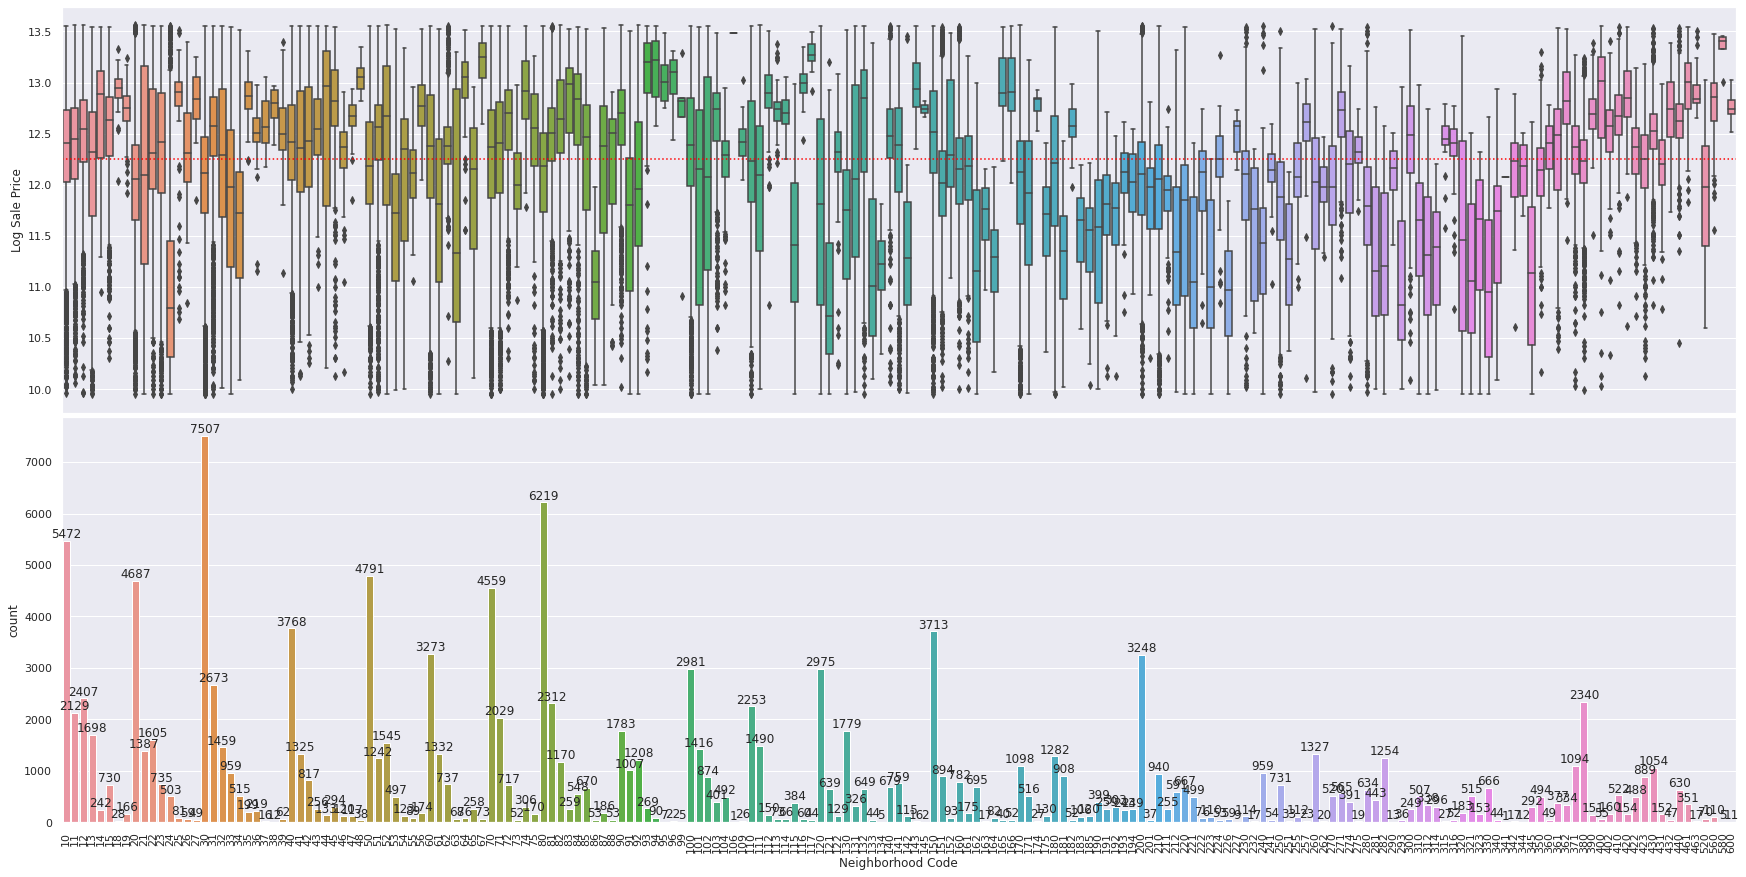

In [26]:
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Neighborhood Code', original_data)

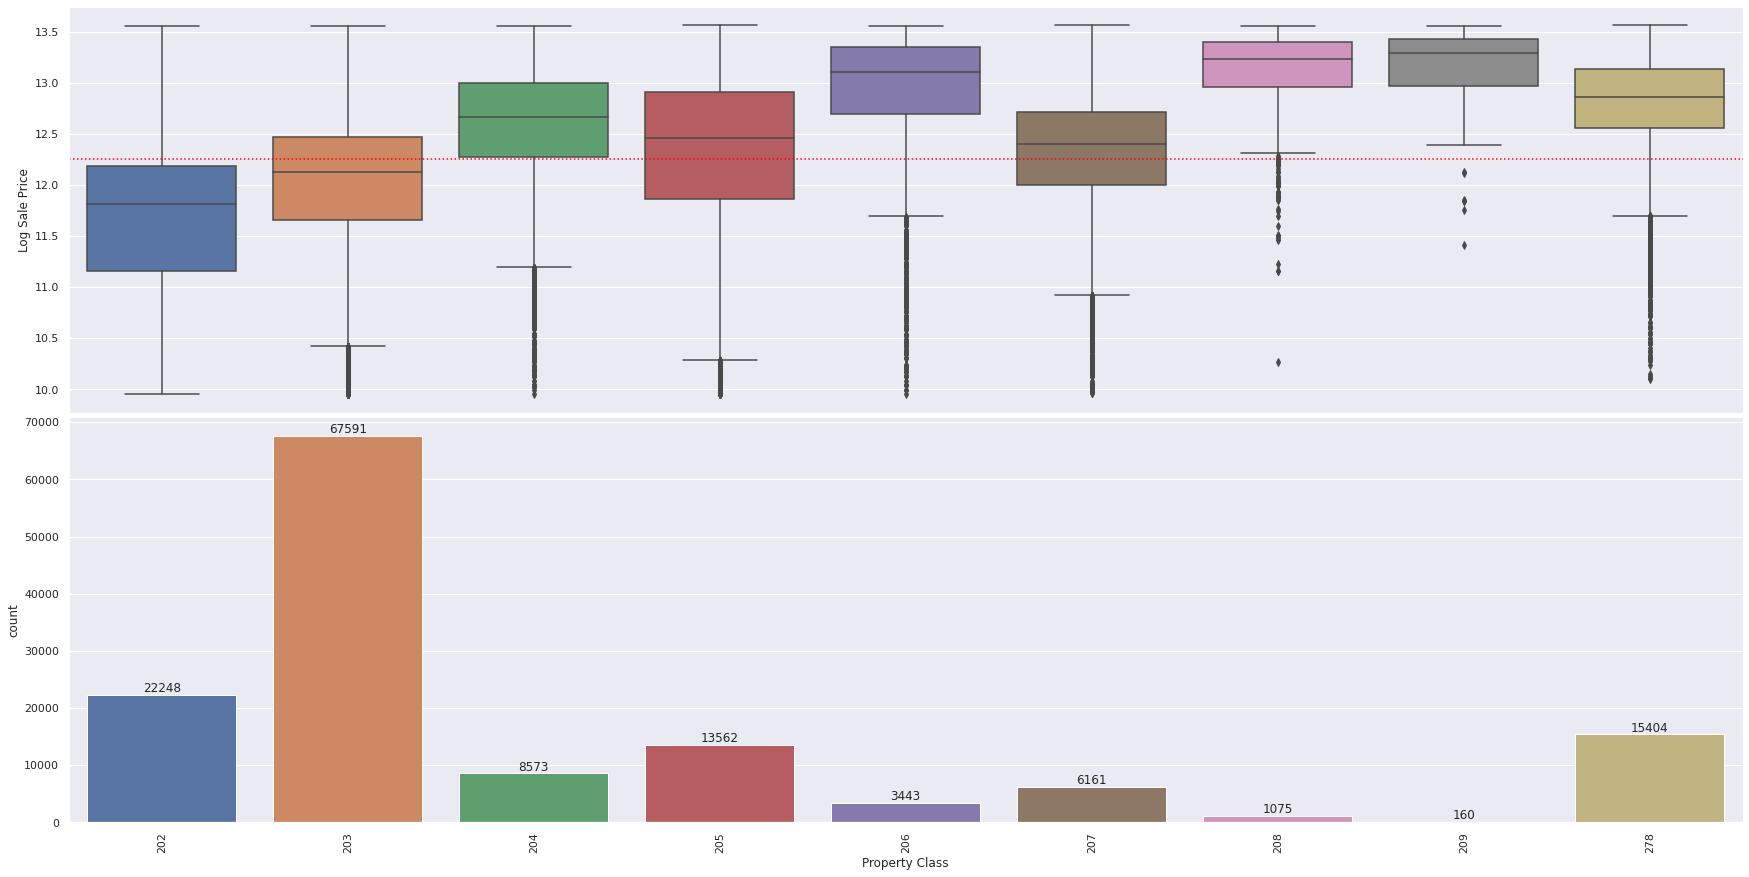

In [27]:
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Property Class', original_data)

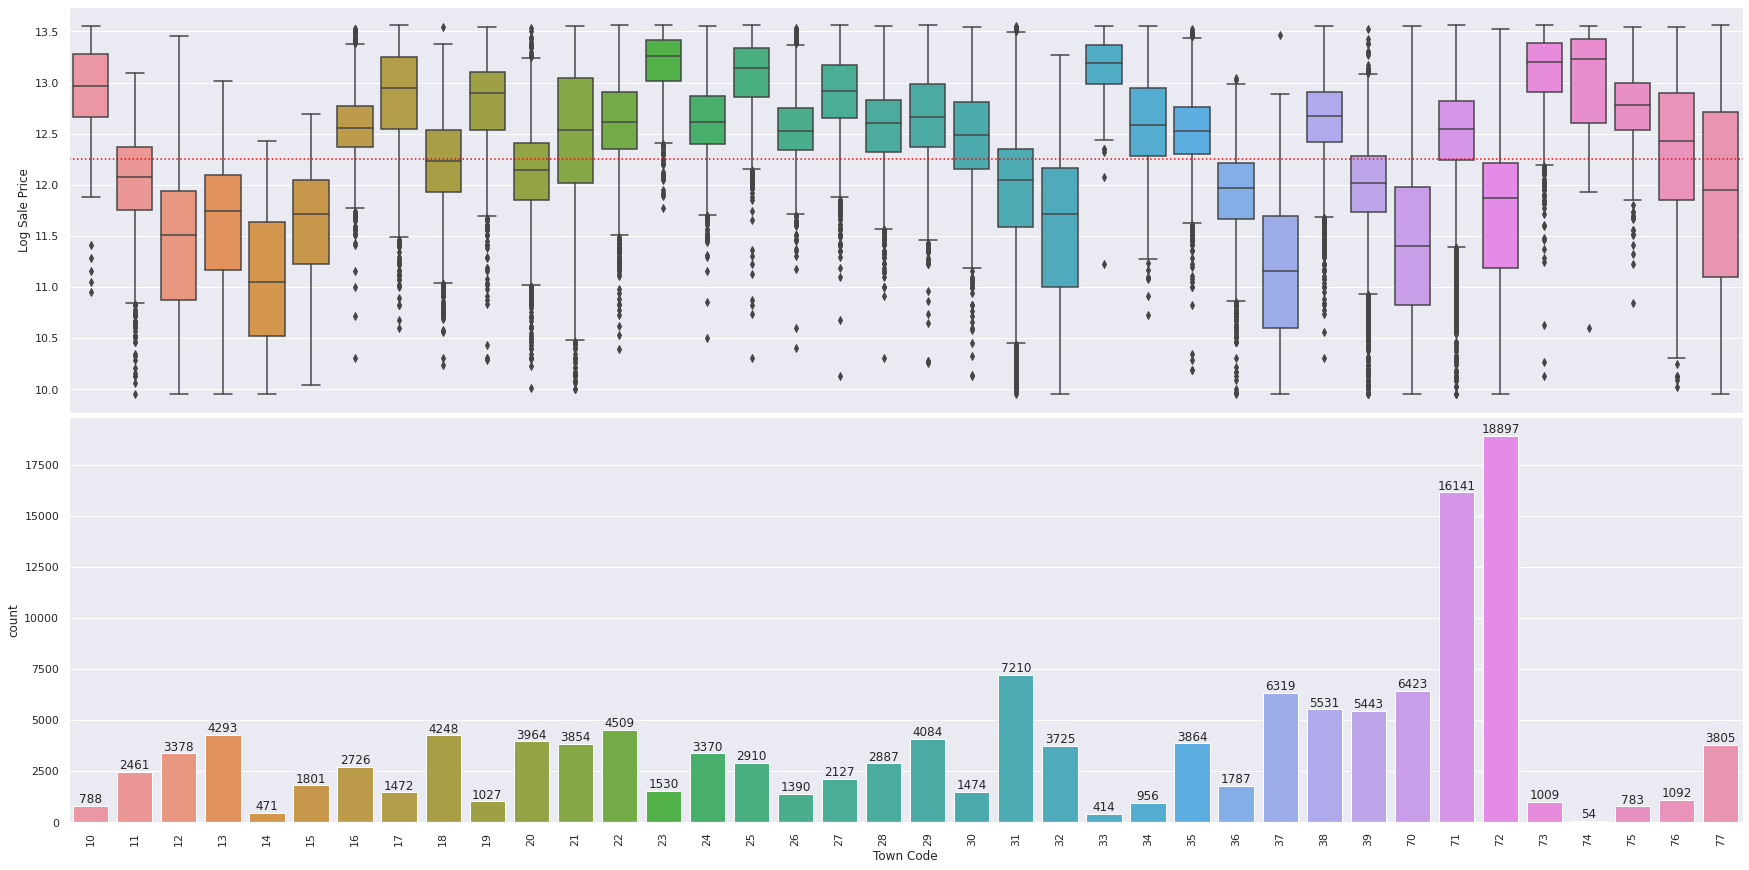

In [10]:
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Town Code', original_data)

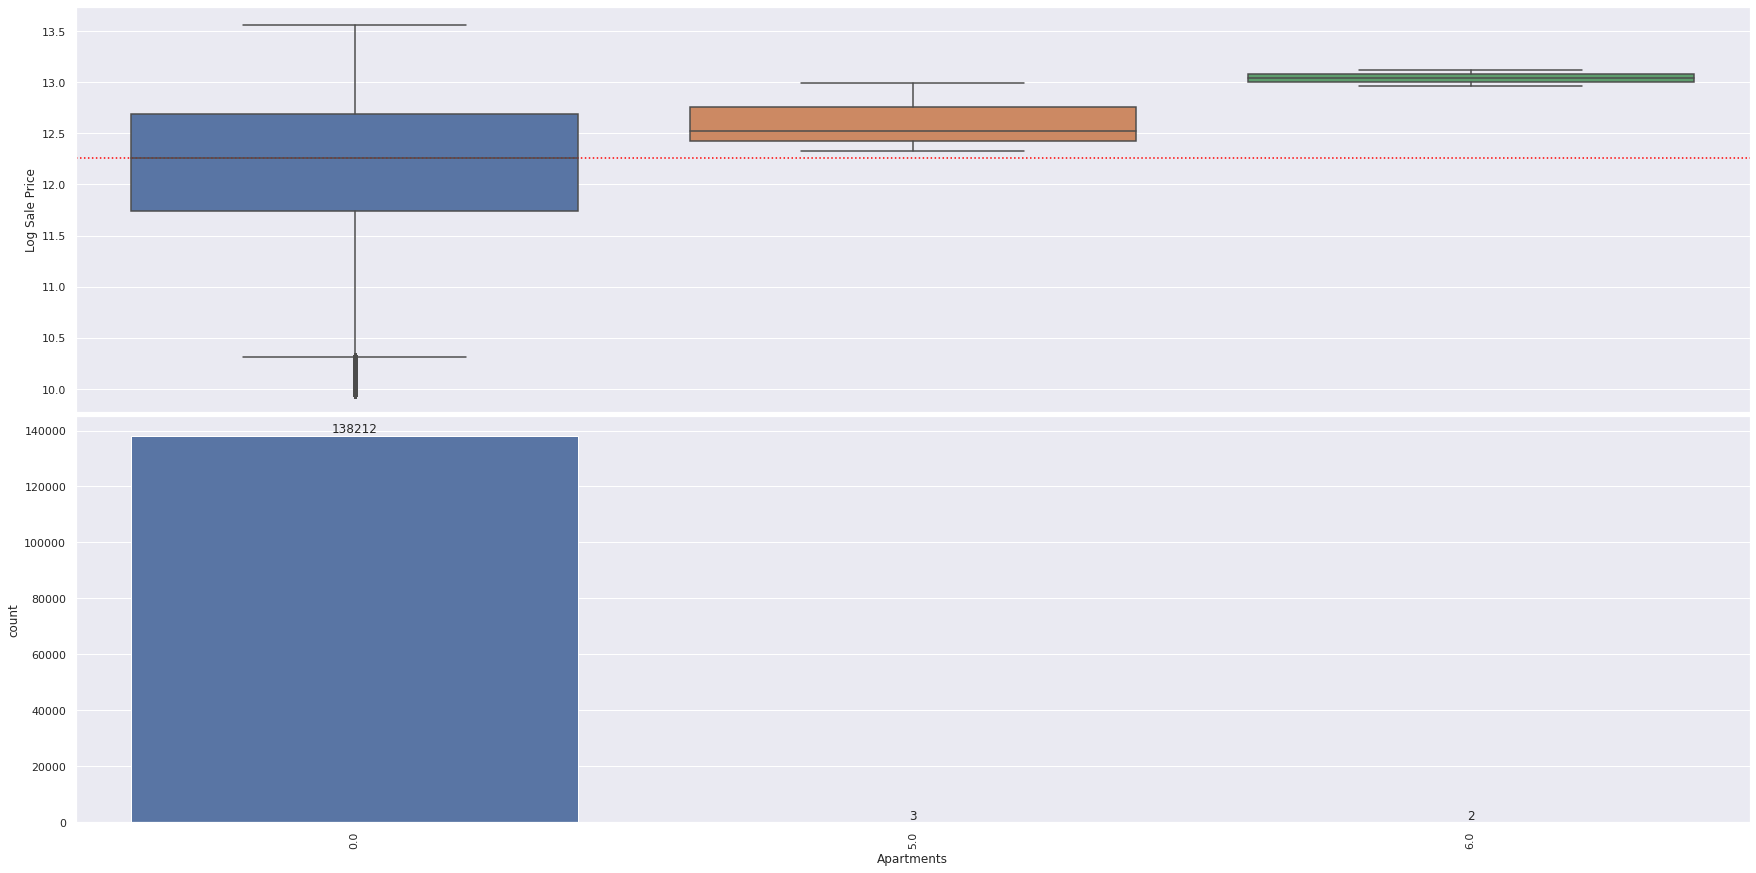

In [11]:
# No use
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Apartments', original_data)

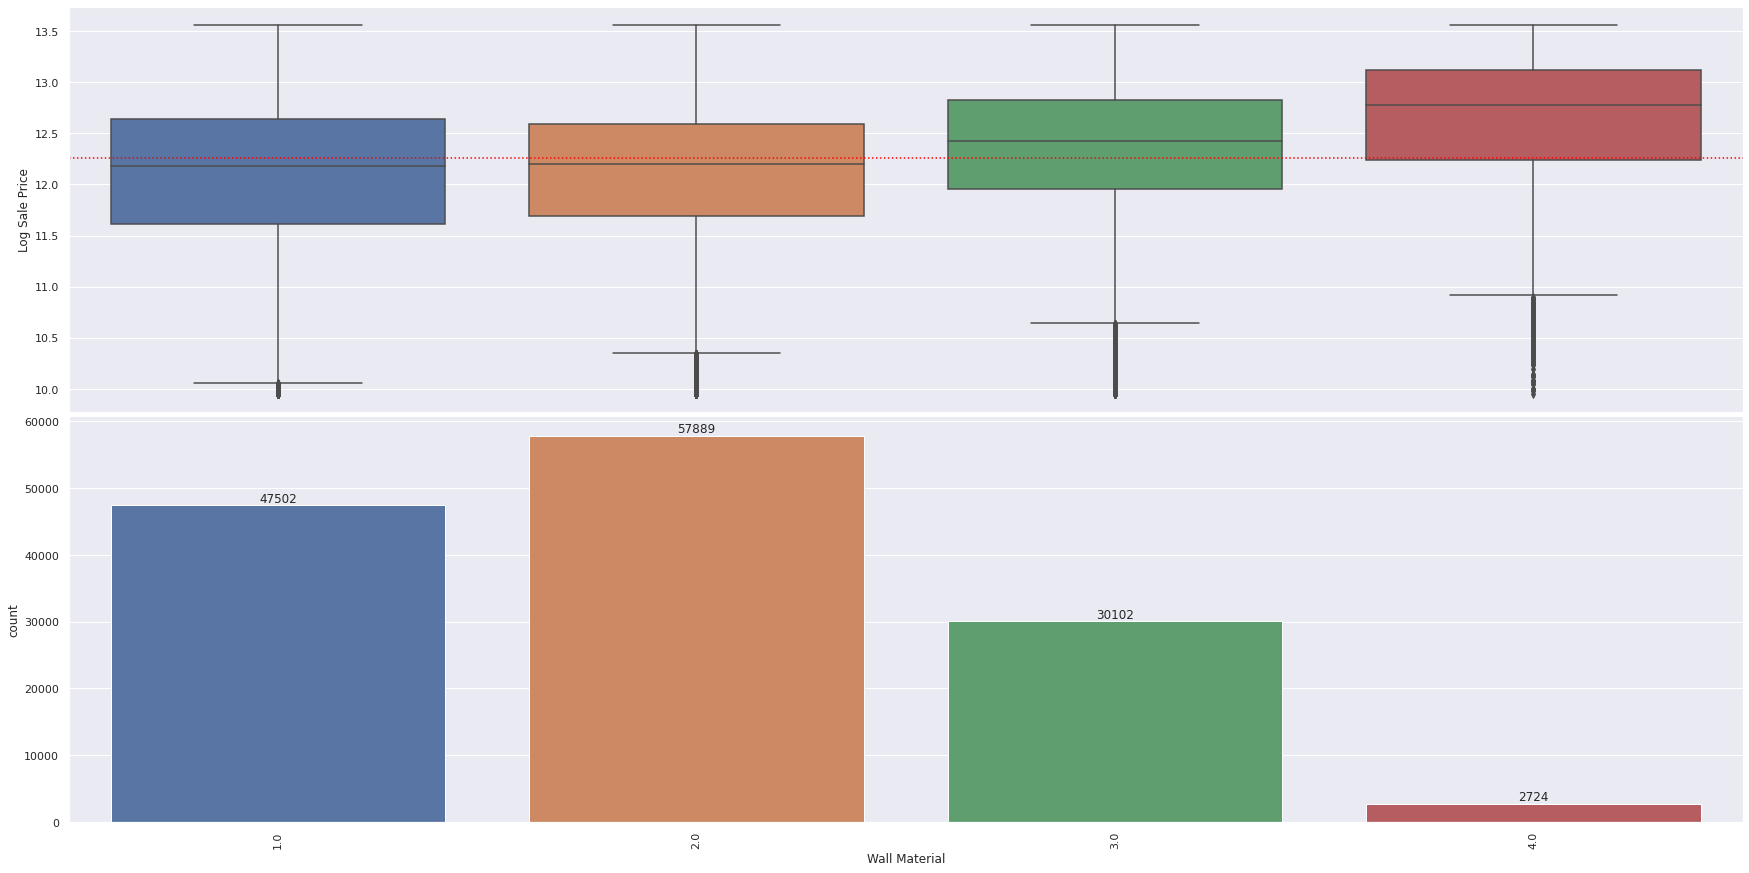

In [12]:
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Wall Material', original_data)

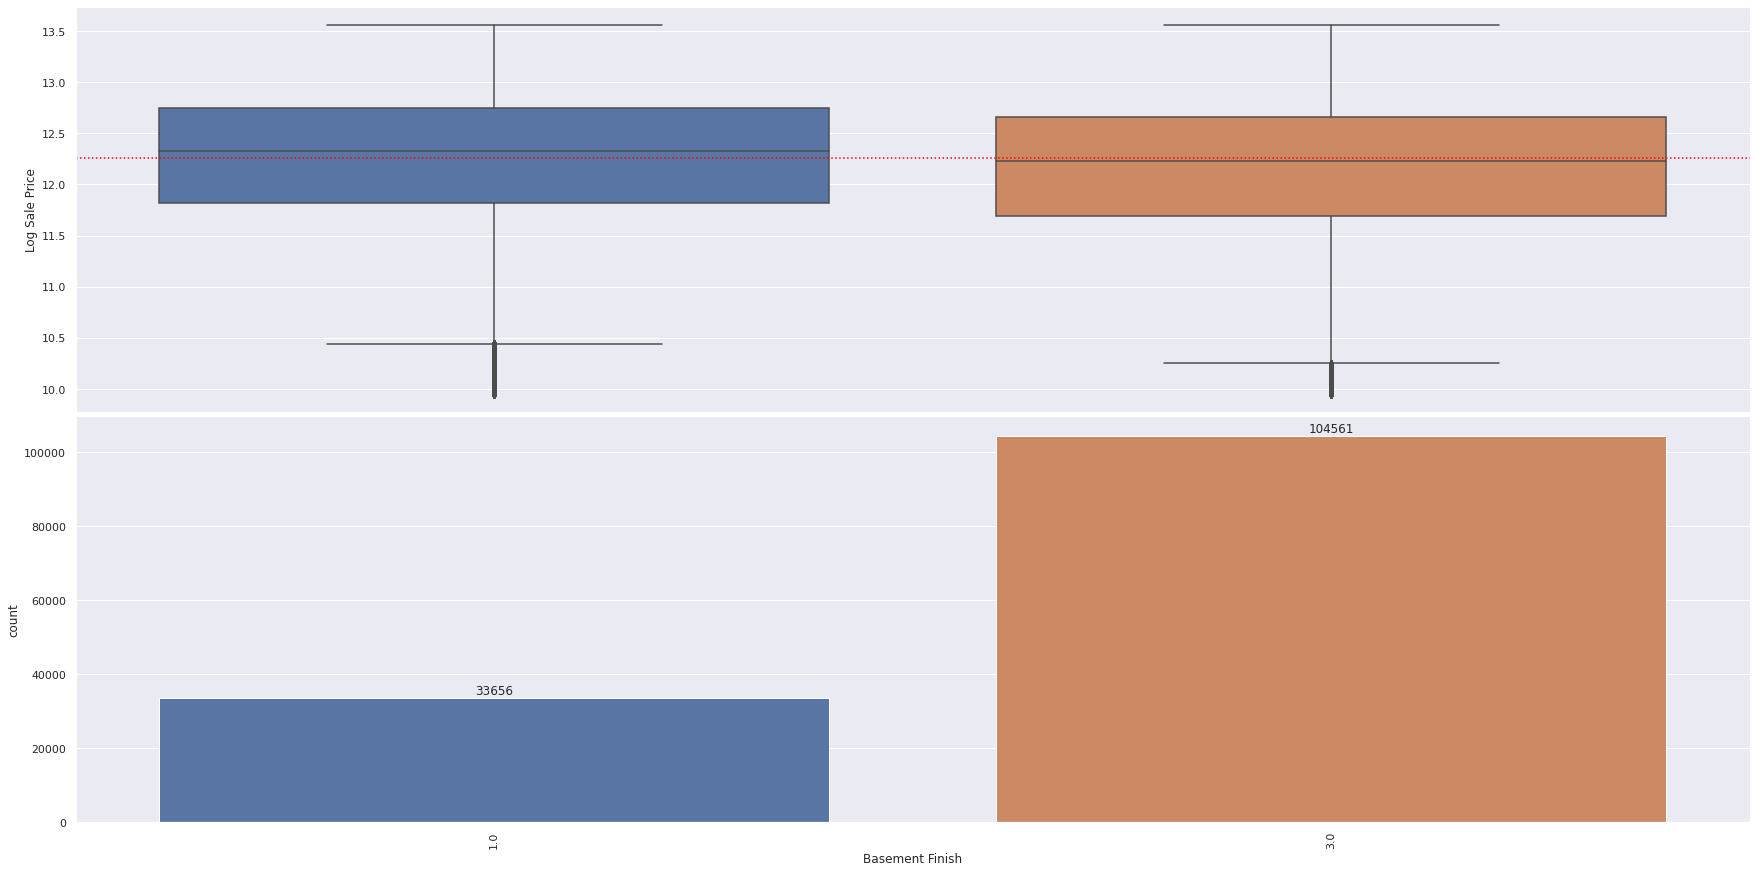

In [13]:
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Basement Finish', original_data)

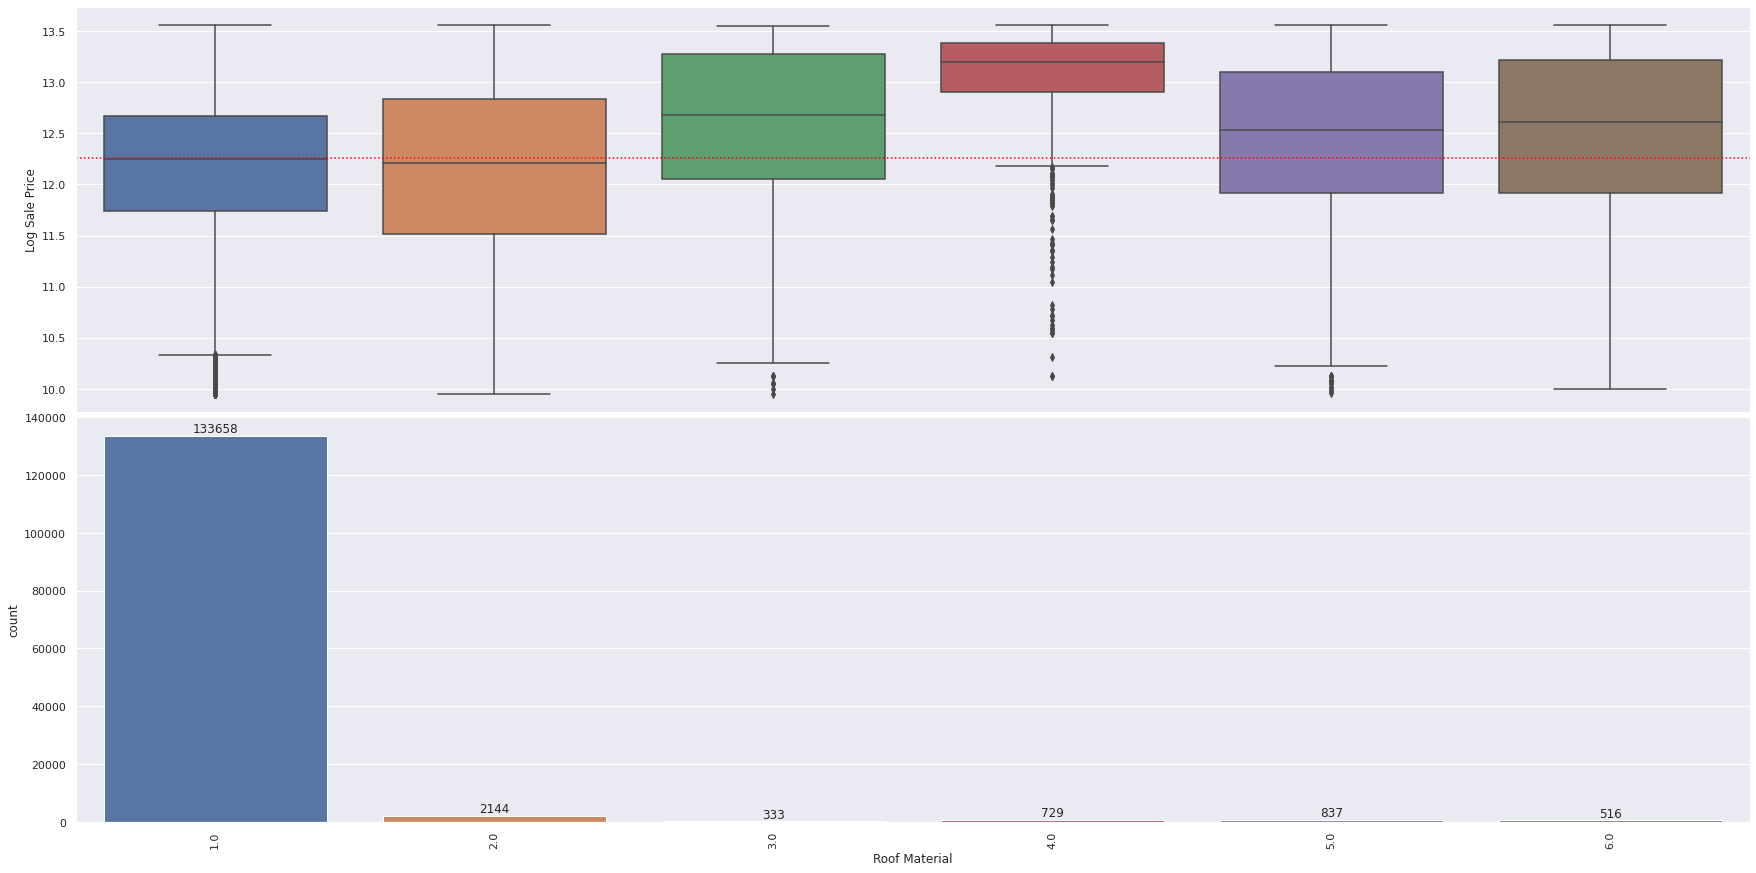

In [20]:
# No use
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Roof Material', original_data)

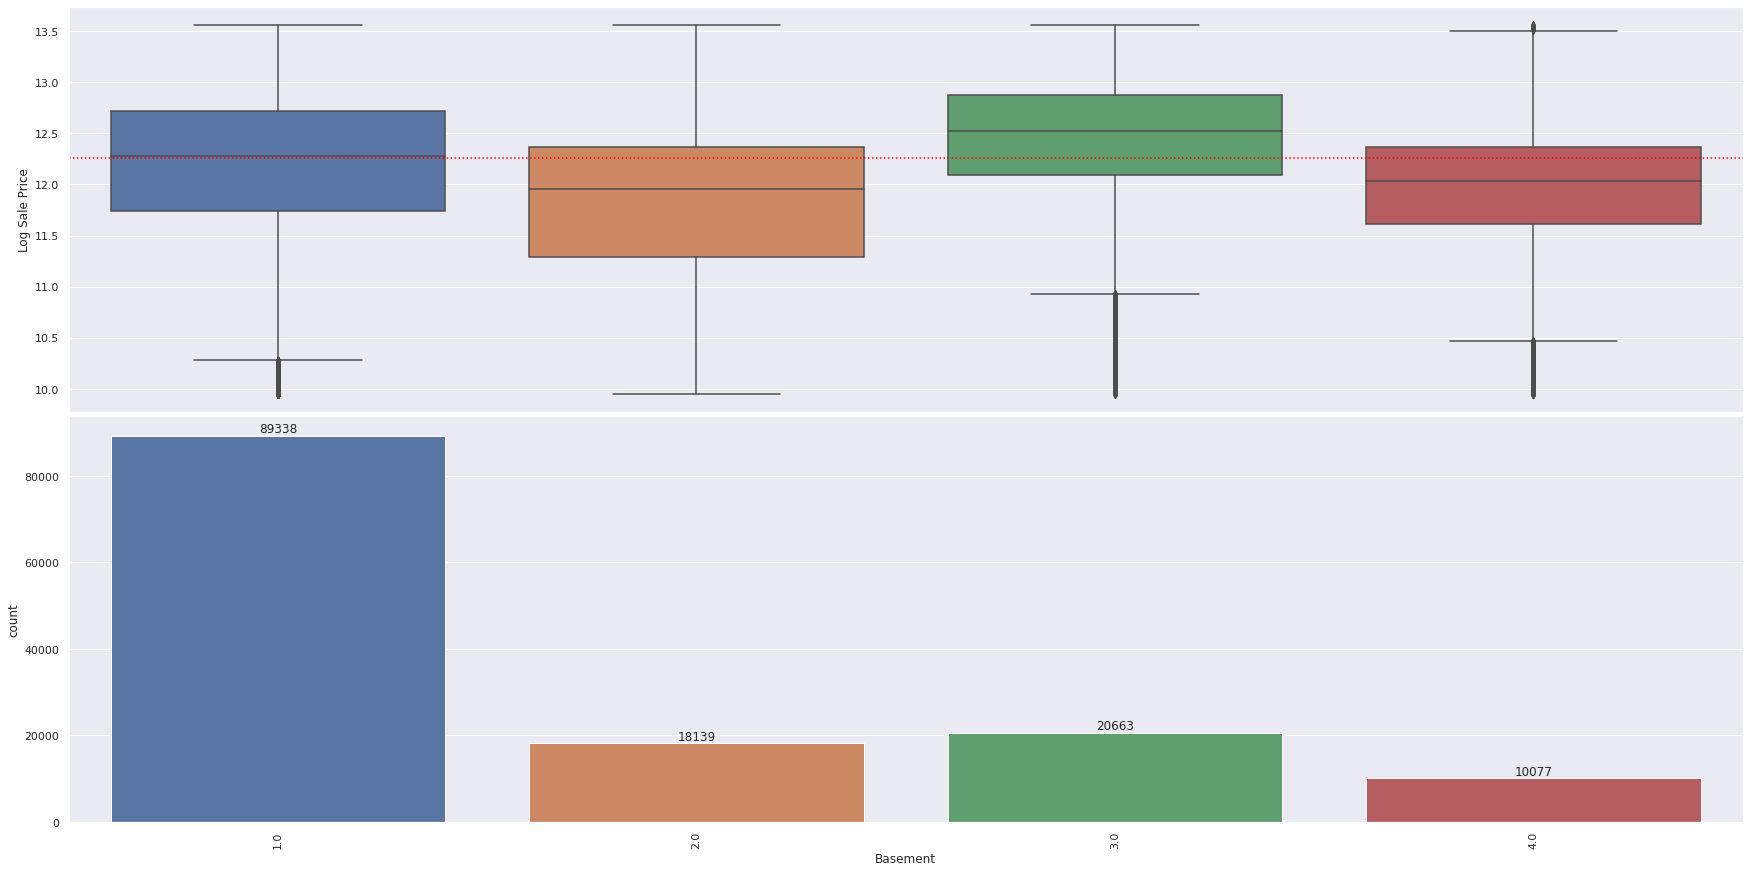

In [21]:
# May have use
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Basement', original_data)

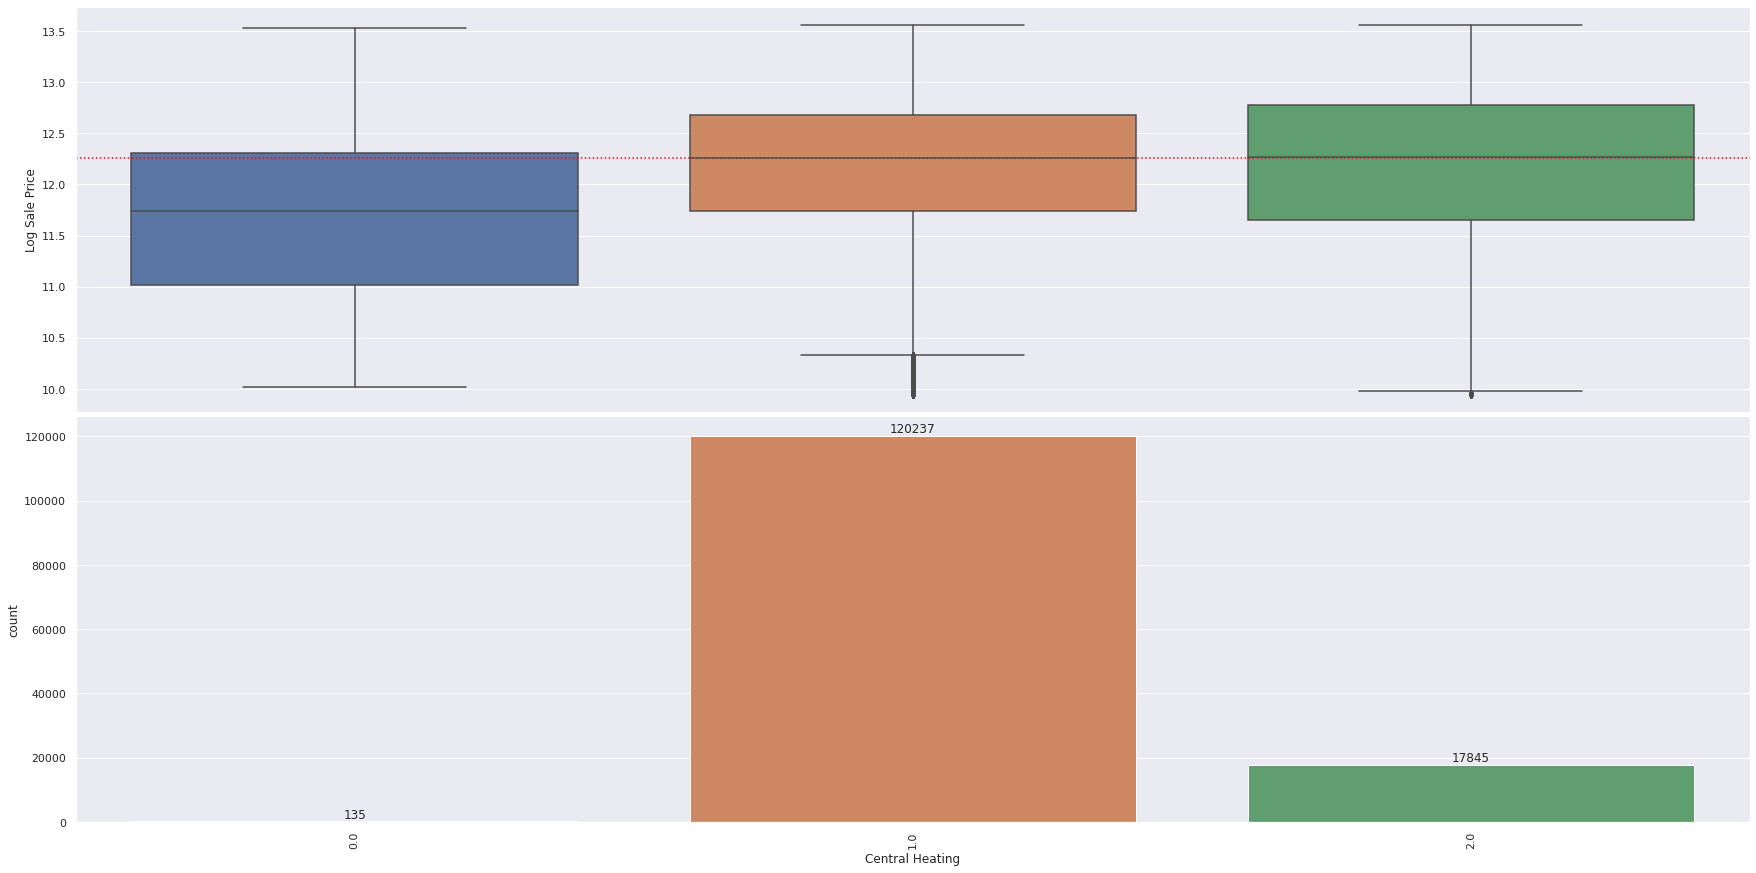

In [26]:
# No use
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Central Heating', original_data)

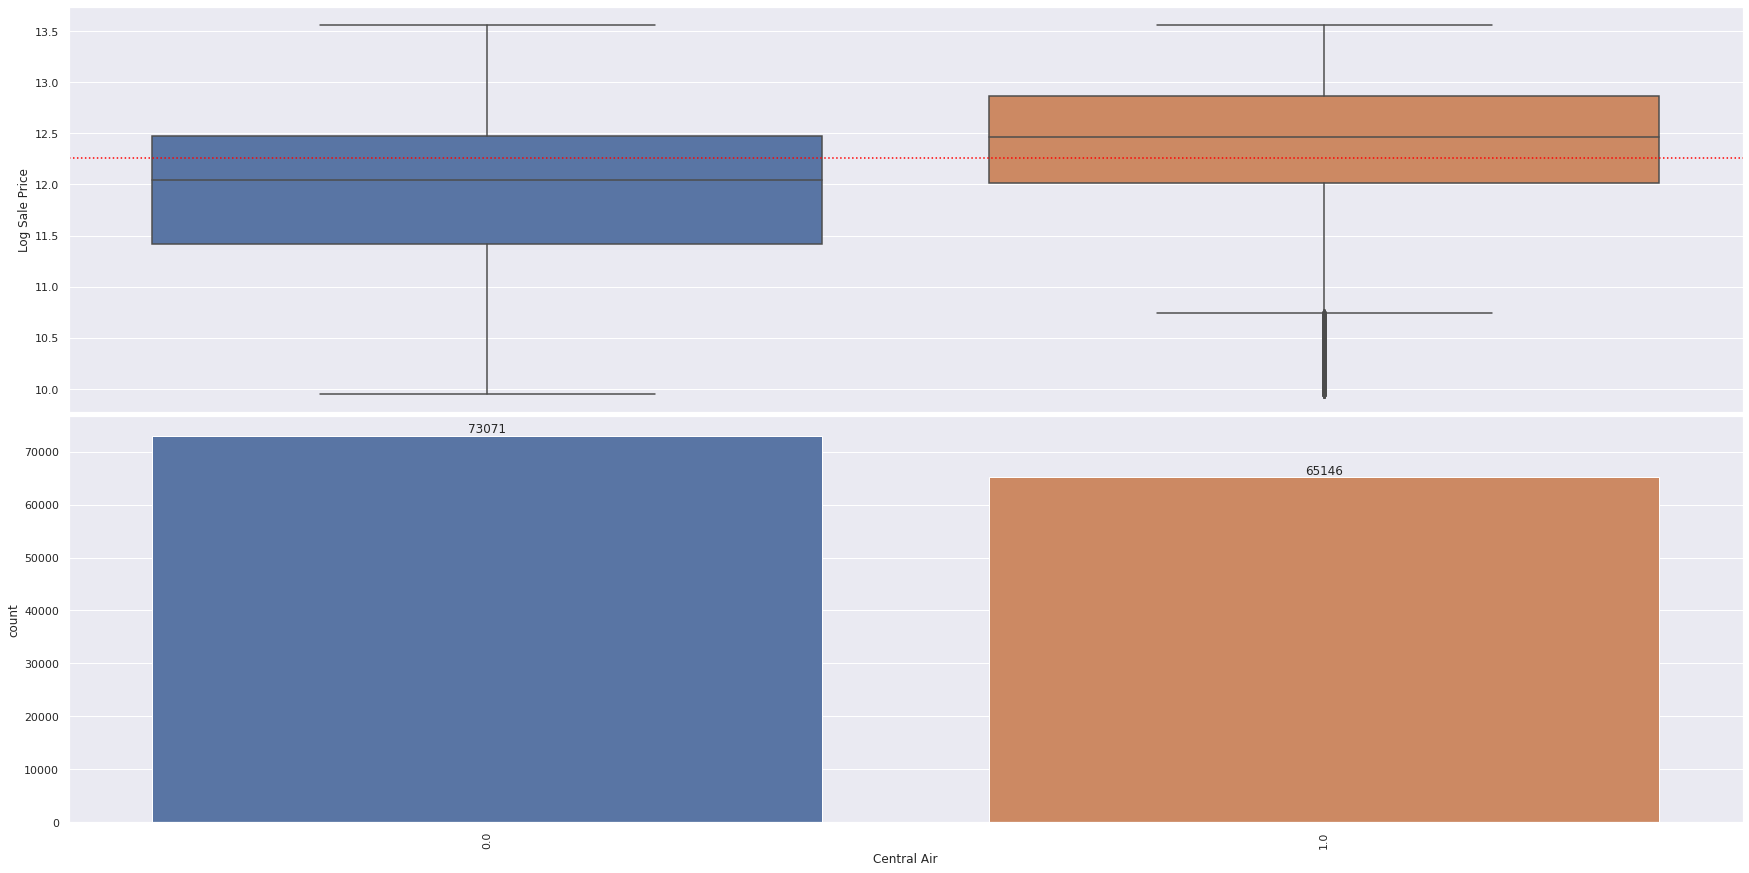

In [27]:
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Central Air', original_data)

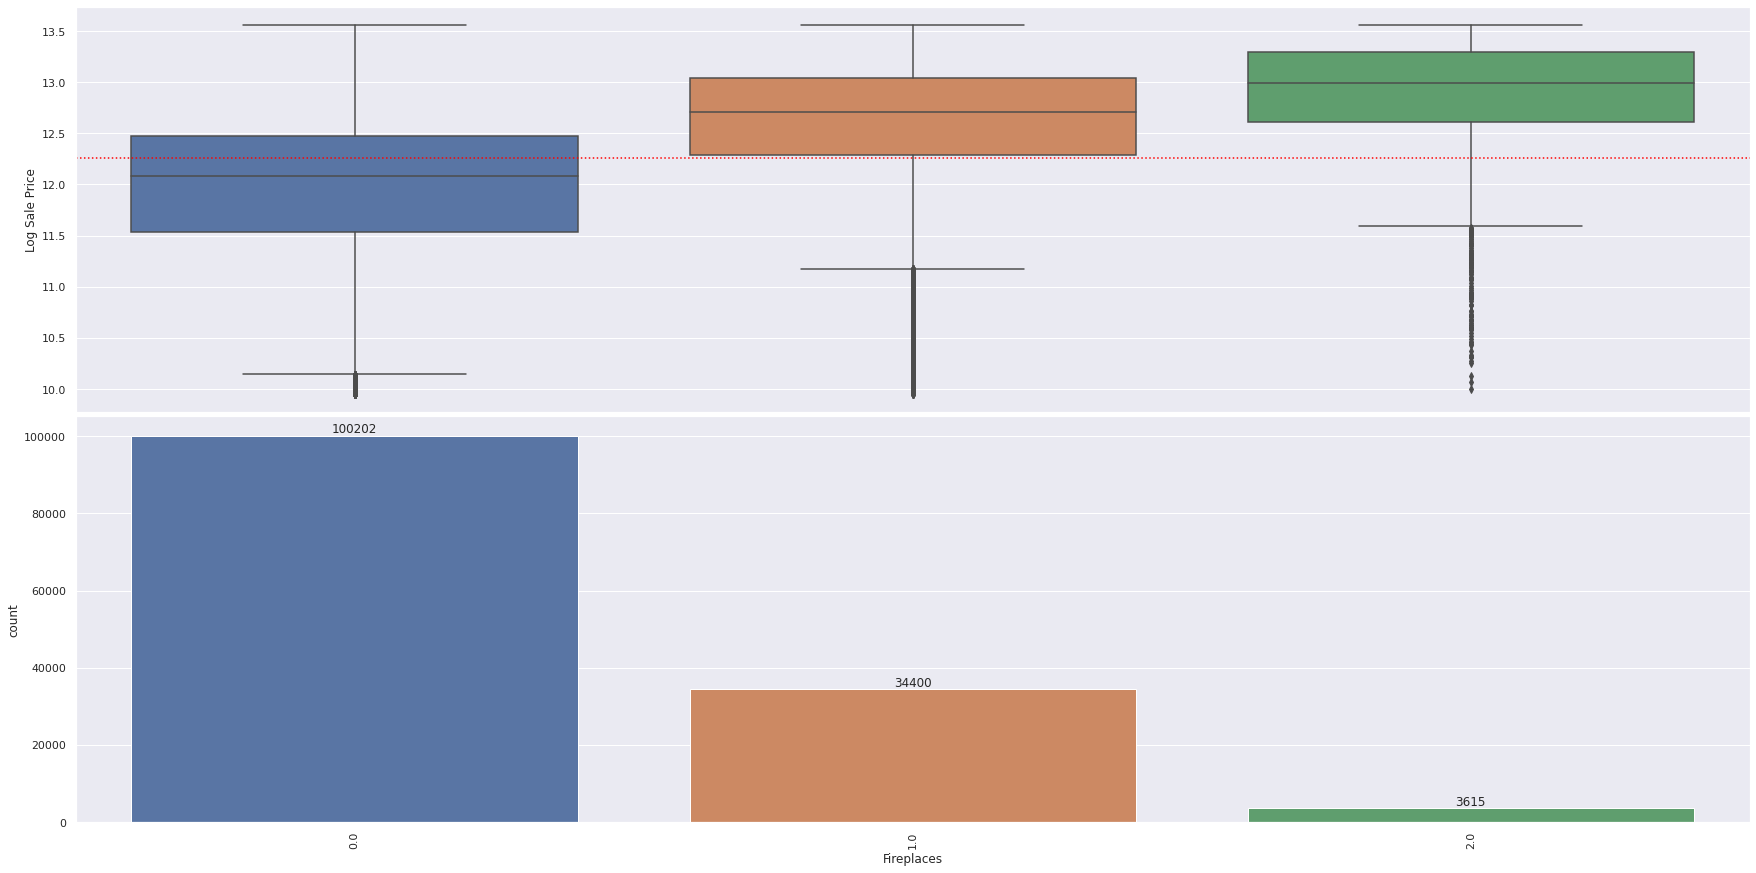

In [30]:
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Fireplaces', original_data)

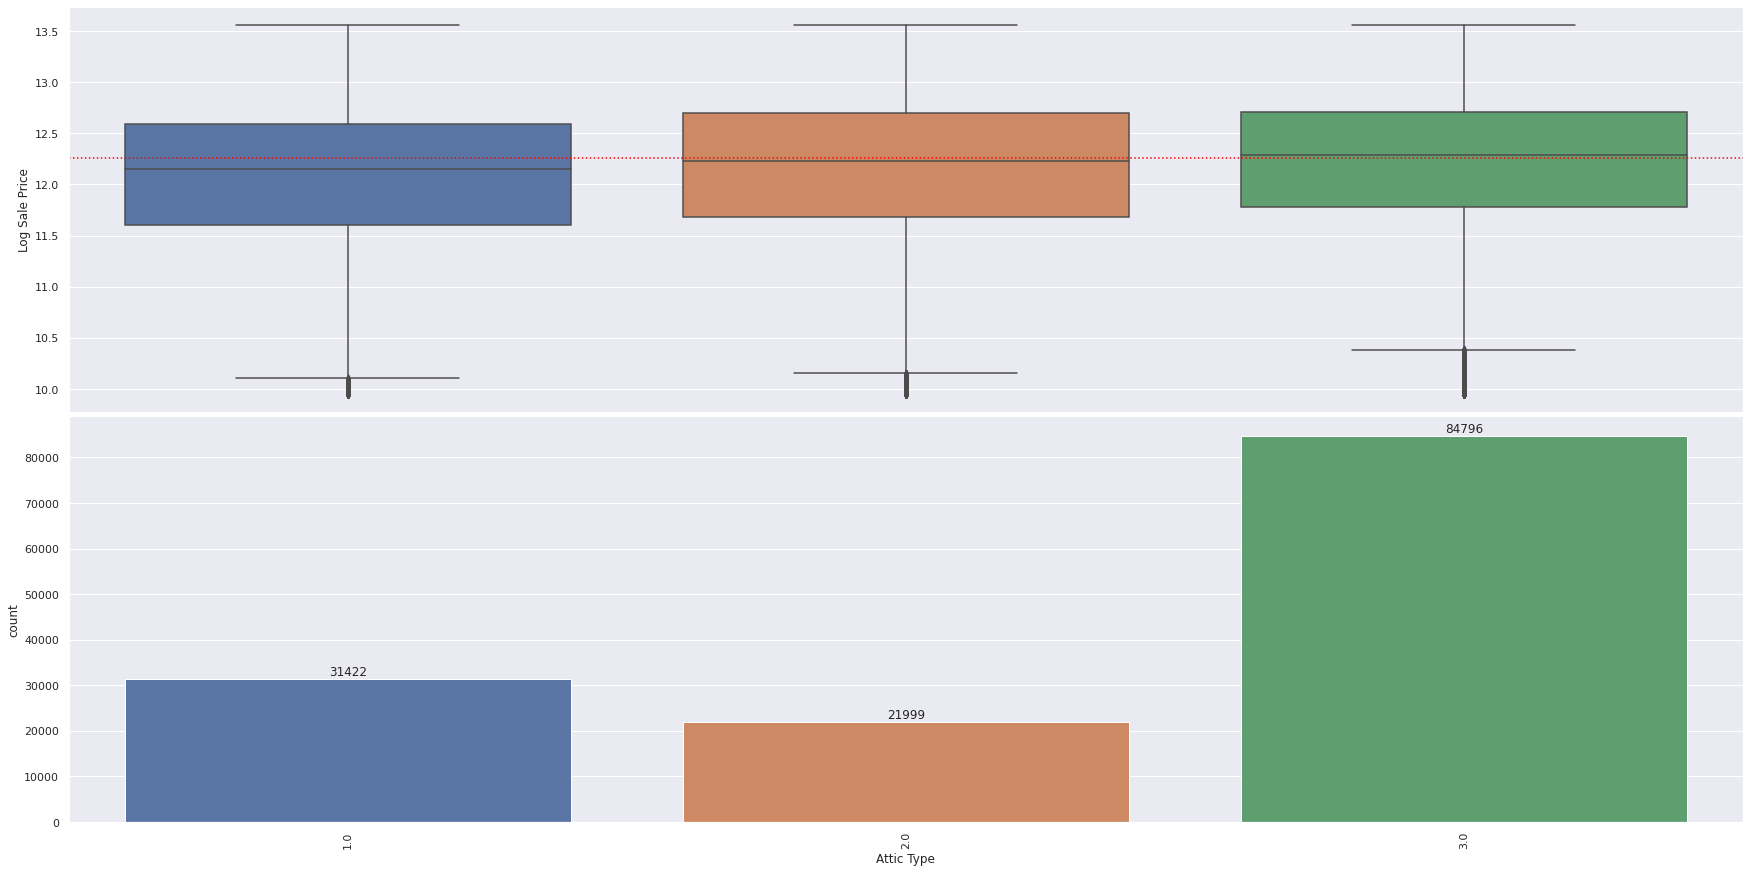

In [33]:
# No use
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Attic Type', original_data)

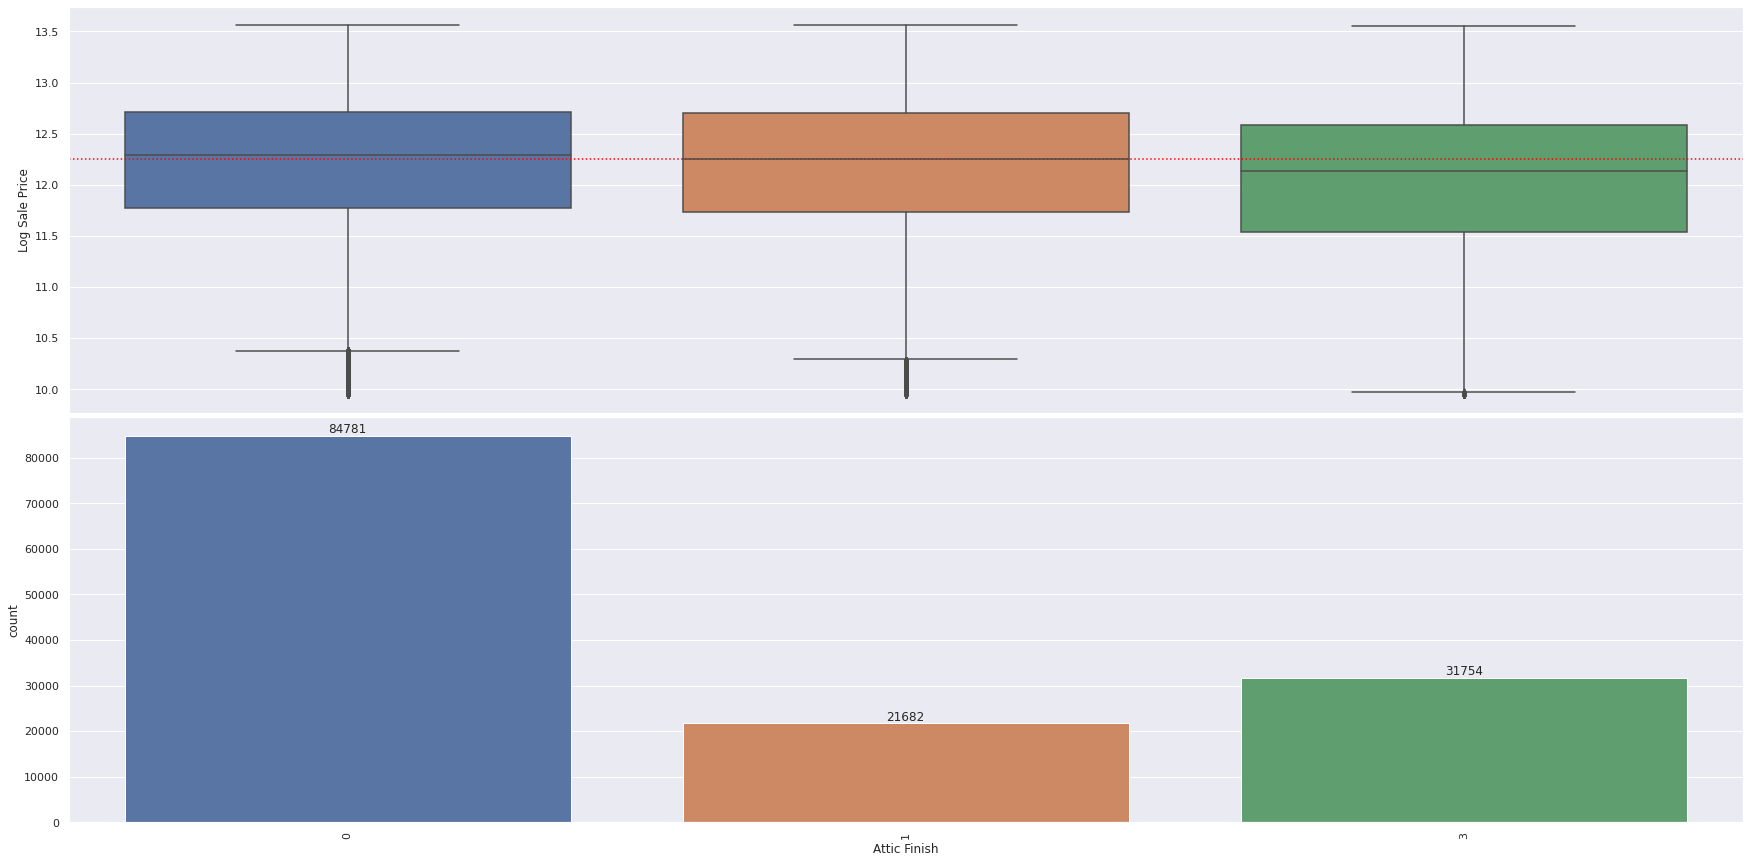

In [34]:
# No Use
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Attic Finish', original_data)

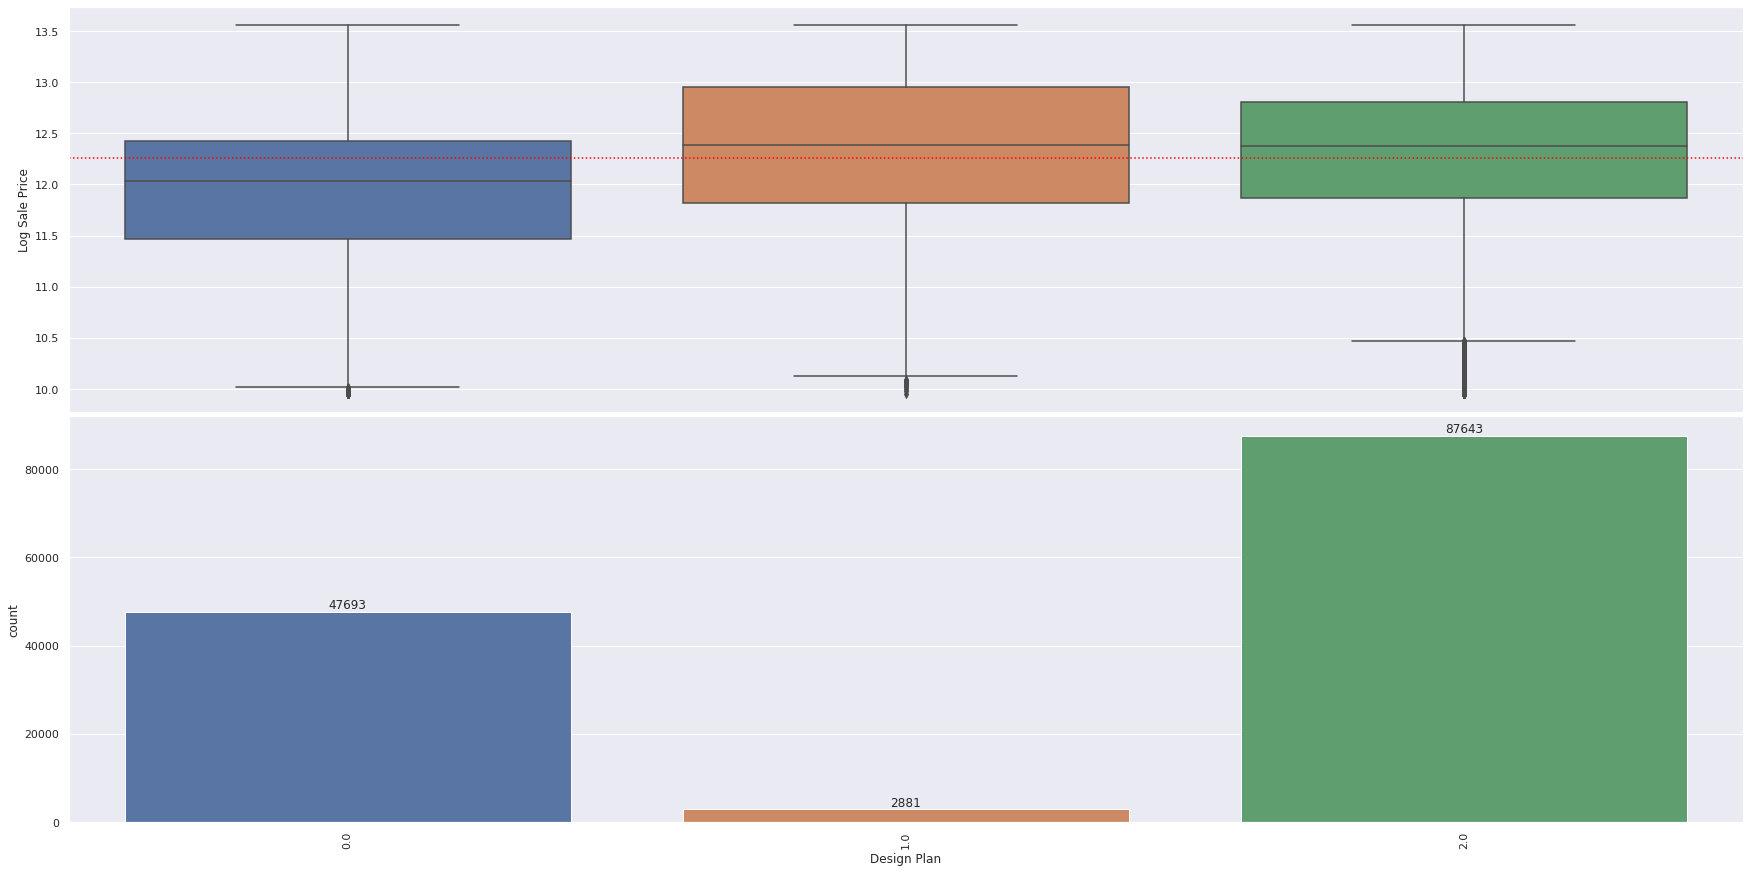

In [35]:
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Design Plan', original_data)

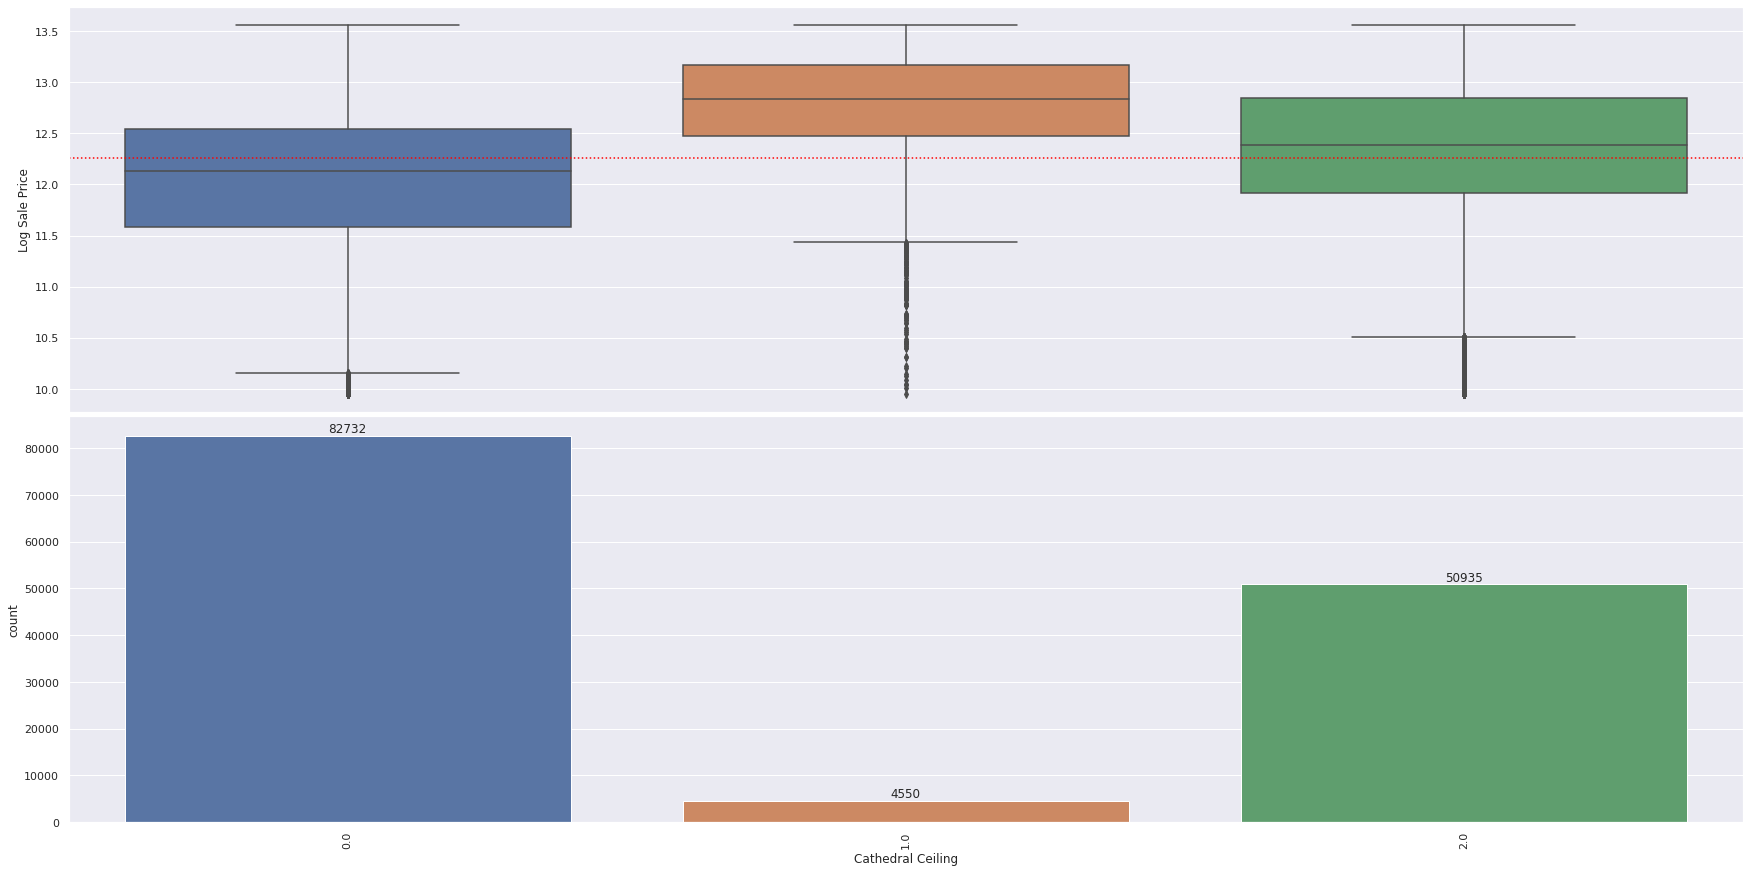

In [38]:
# No use
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Cathedral Ceiling', original_data)

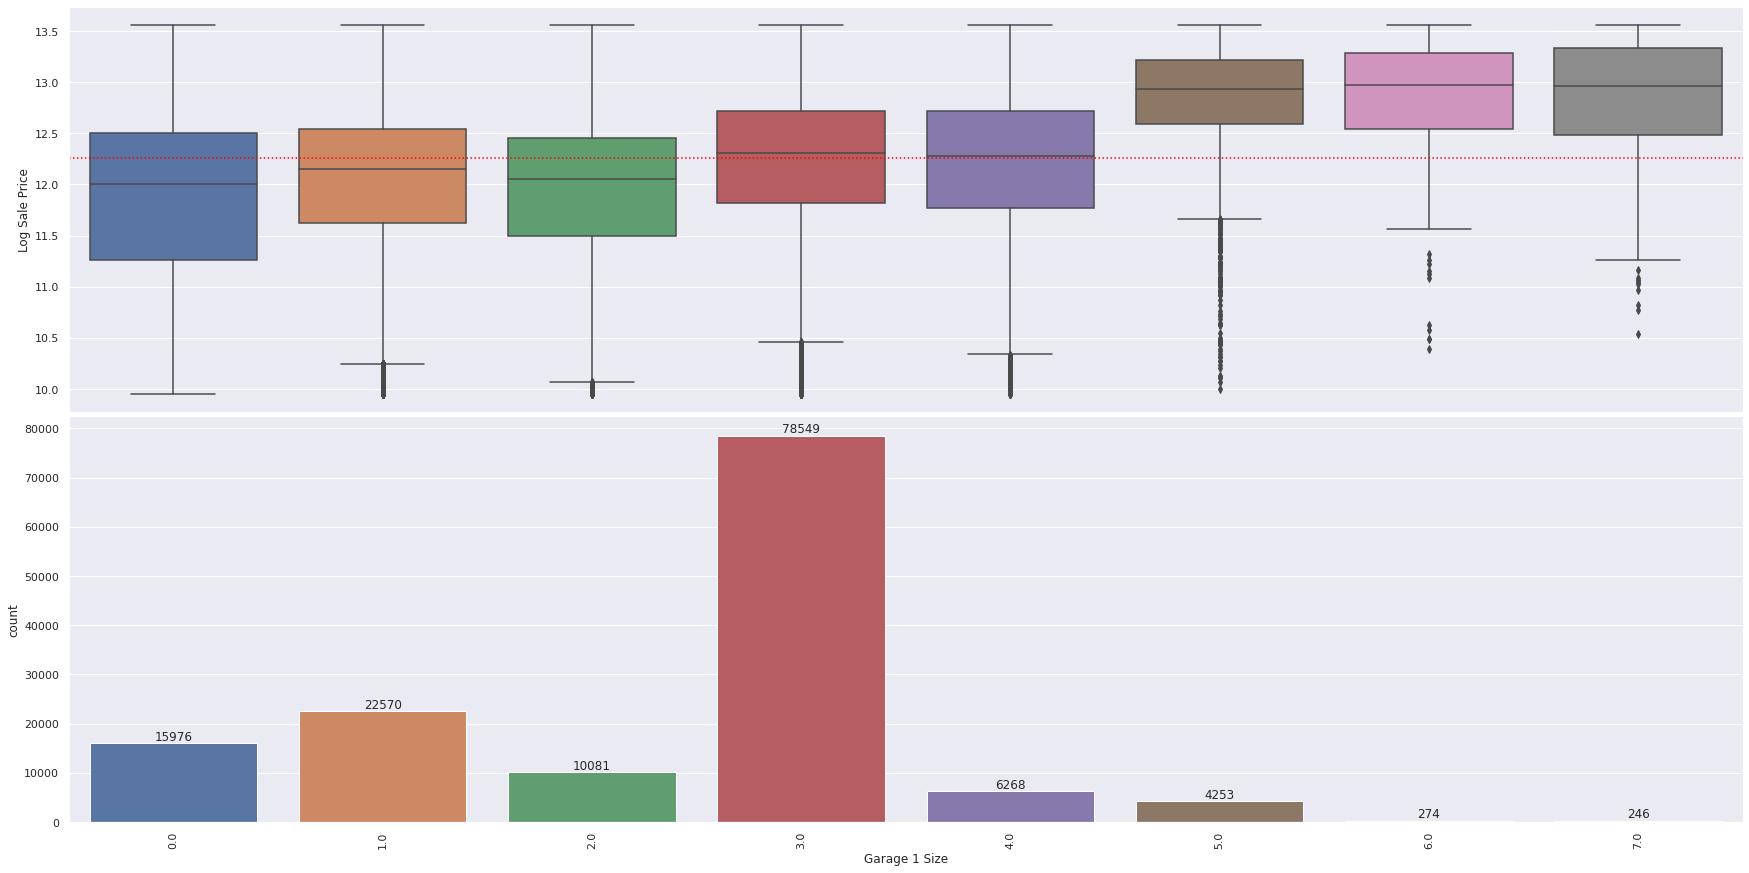

In [39]:
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Garage 1 Size', original_data)

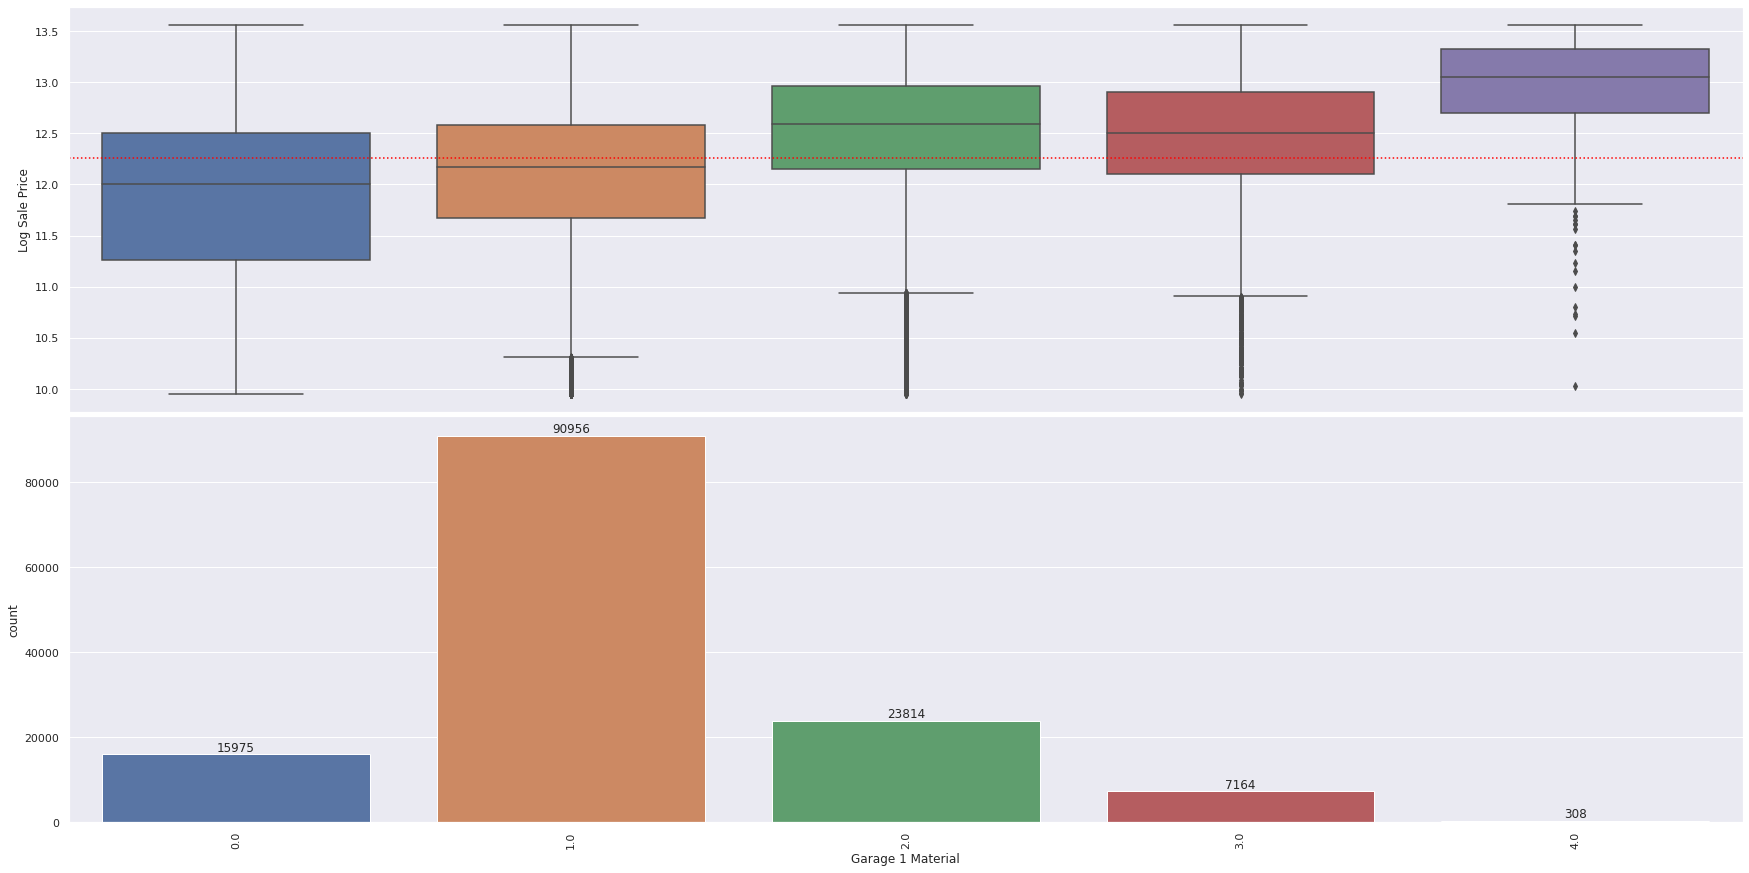

In [40]:
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Garage 1 Material', original_data)

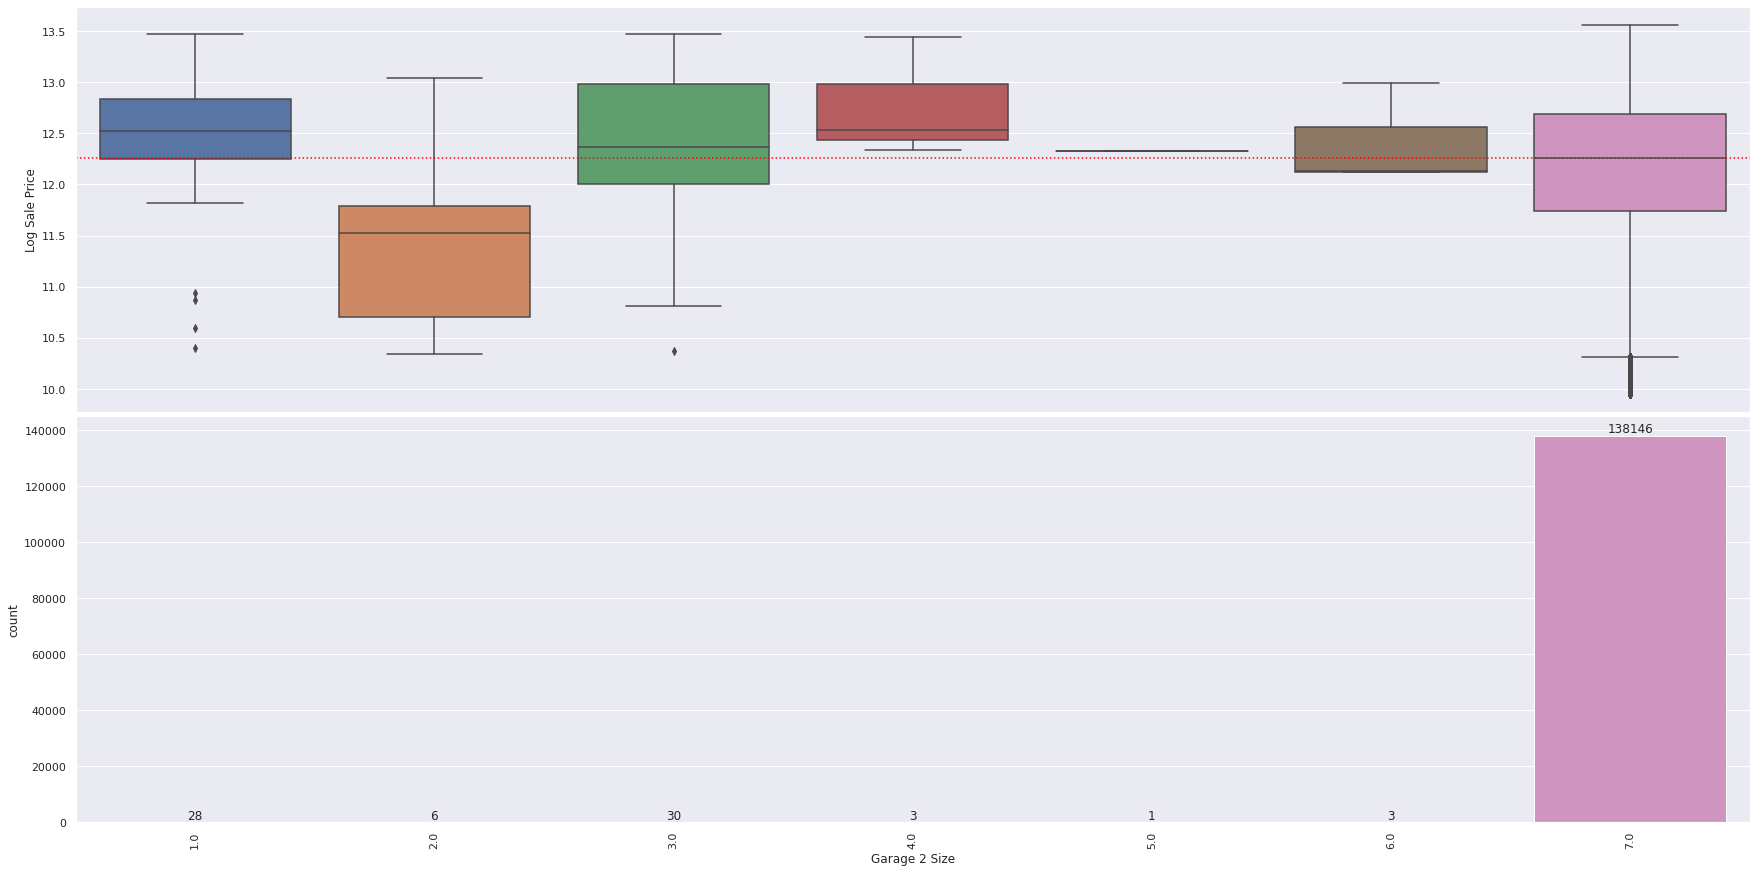

In [41]:
# No use
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Garage 2 Size', original_data)

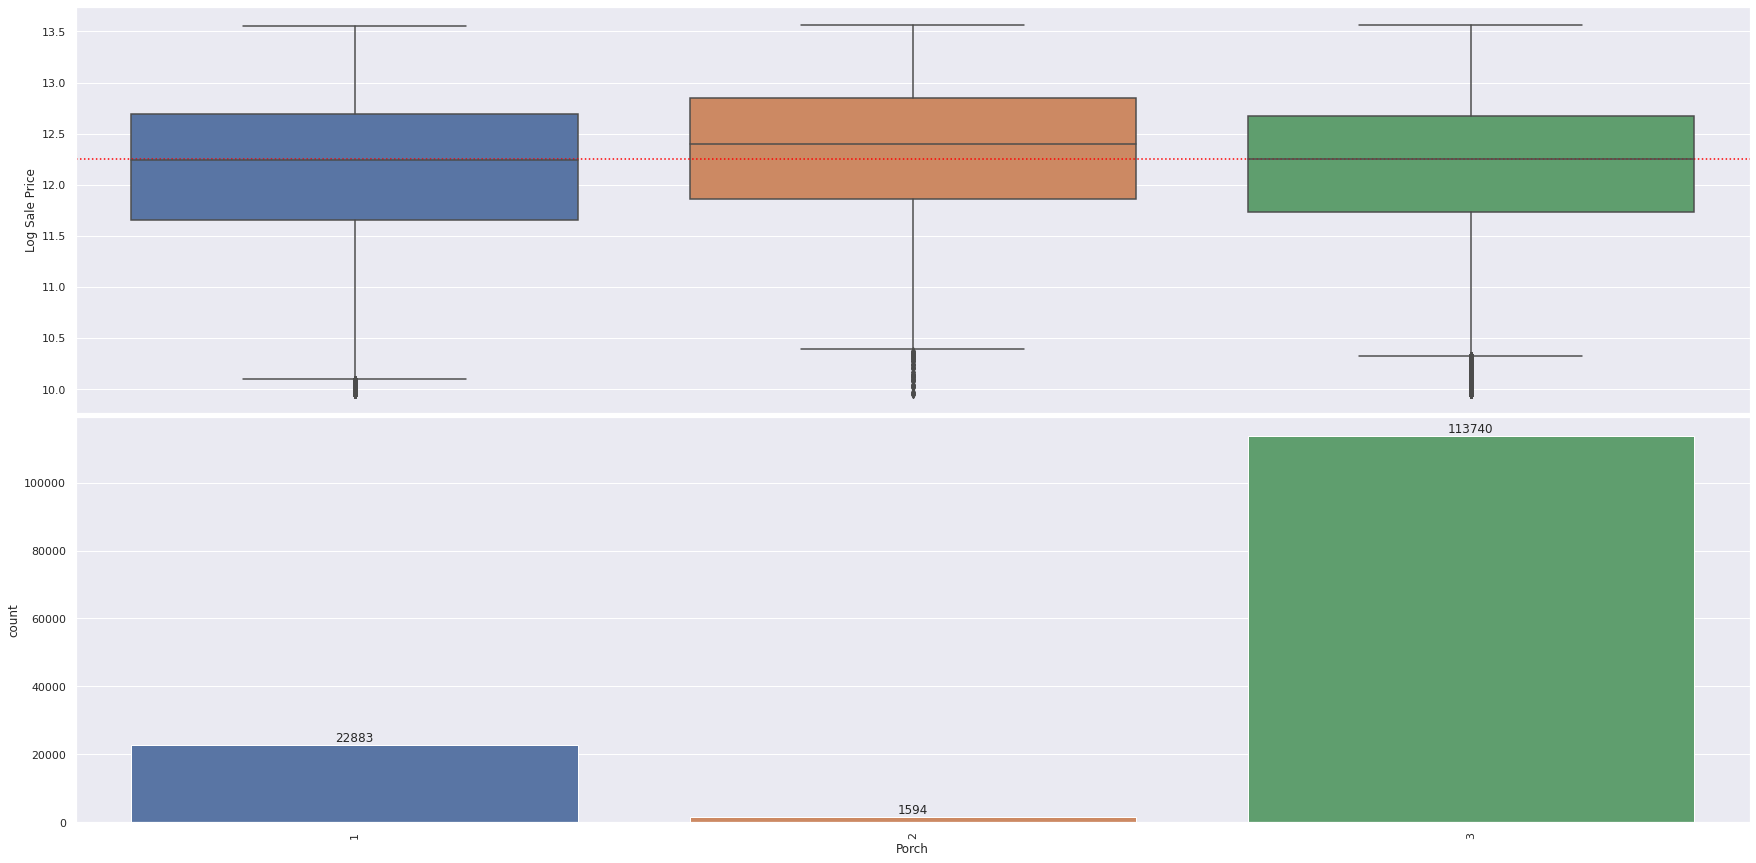

In [46]:
# No use
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Porch', original_data)

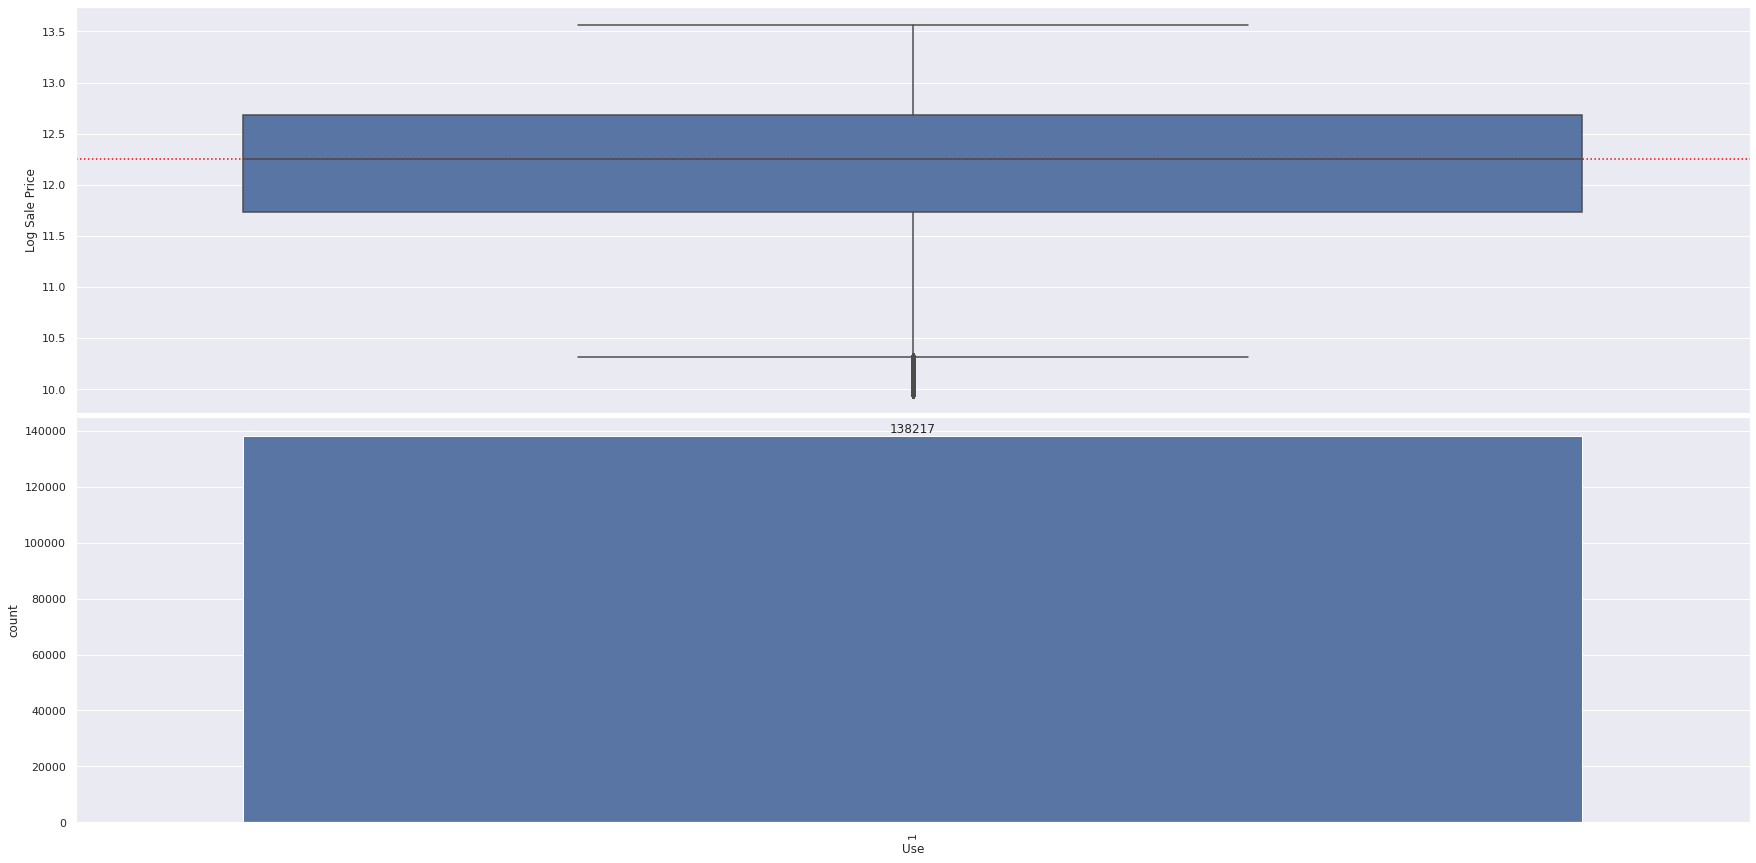

In [47]:
# No use
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Use', original_data)

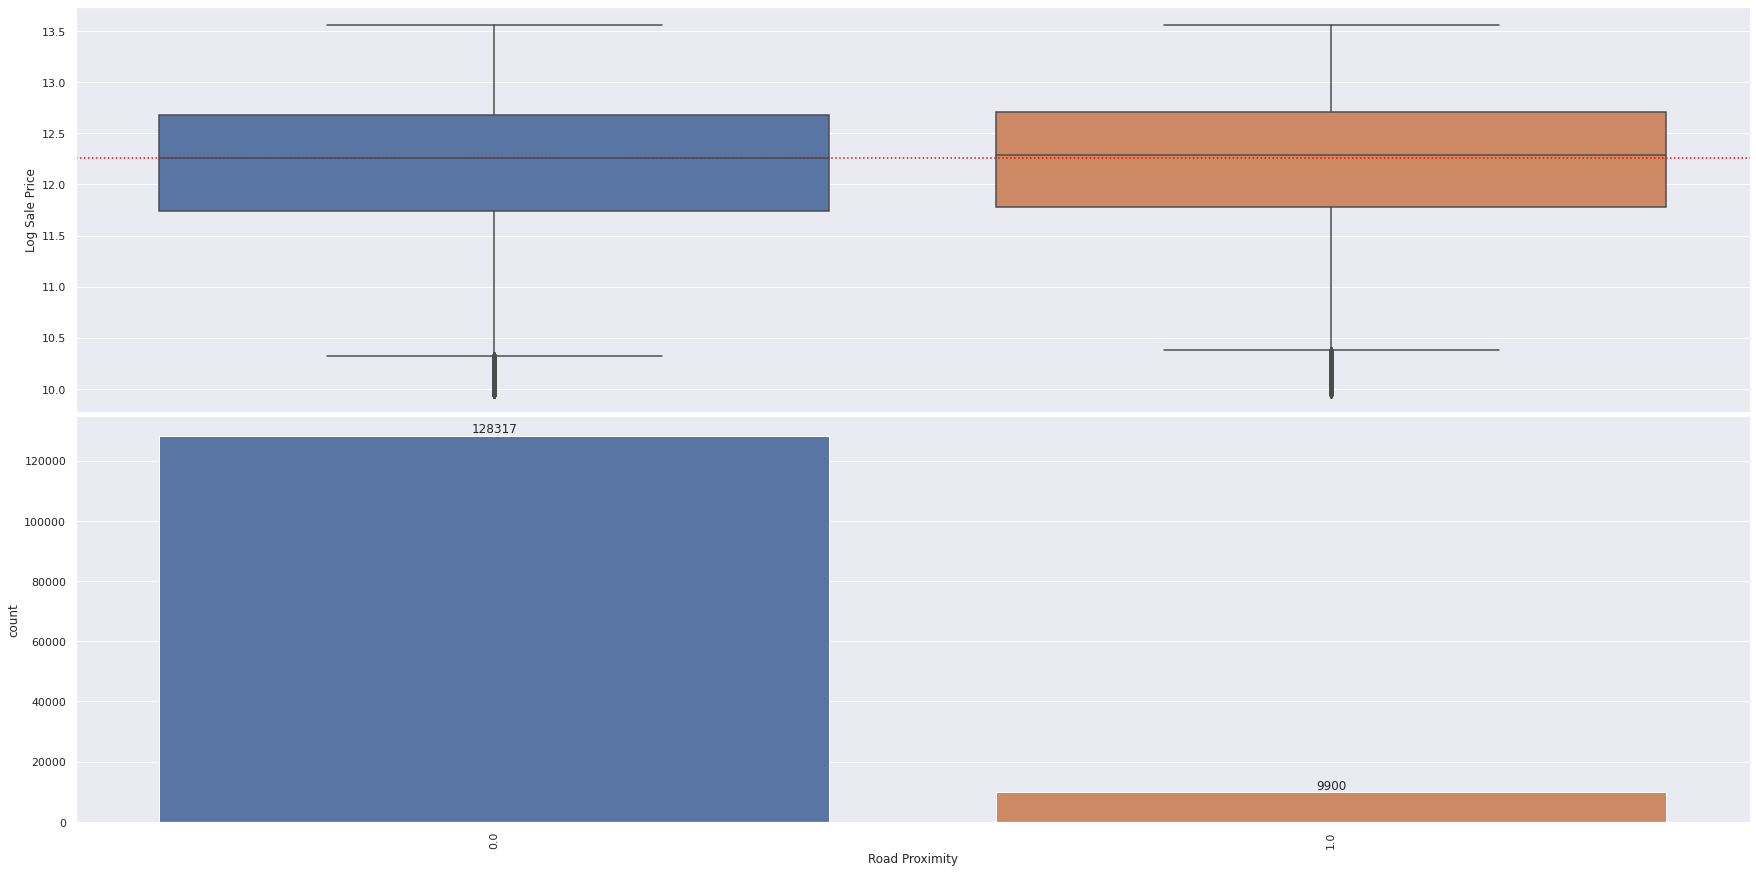

In [48]:
# No use
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Road Proximity', original_data)

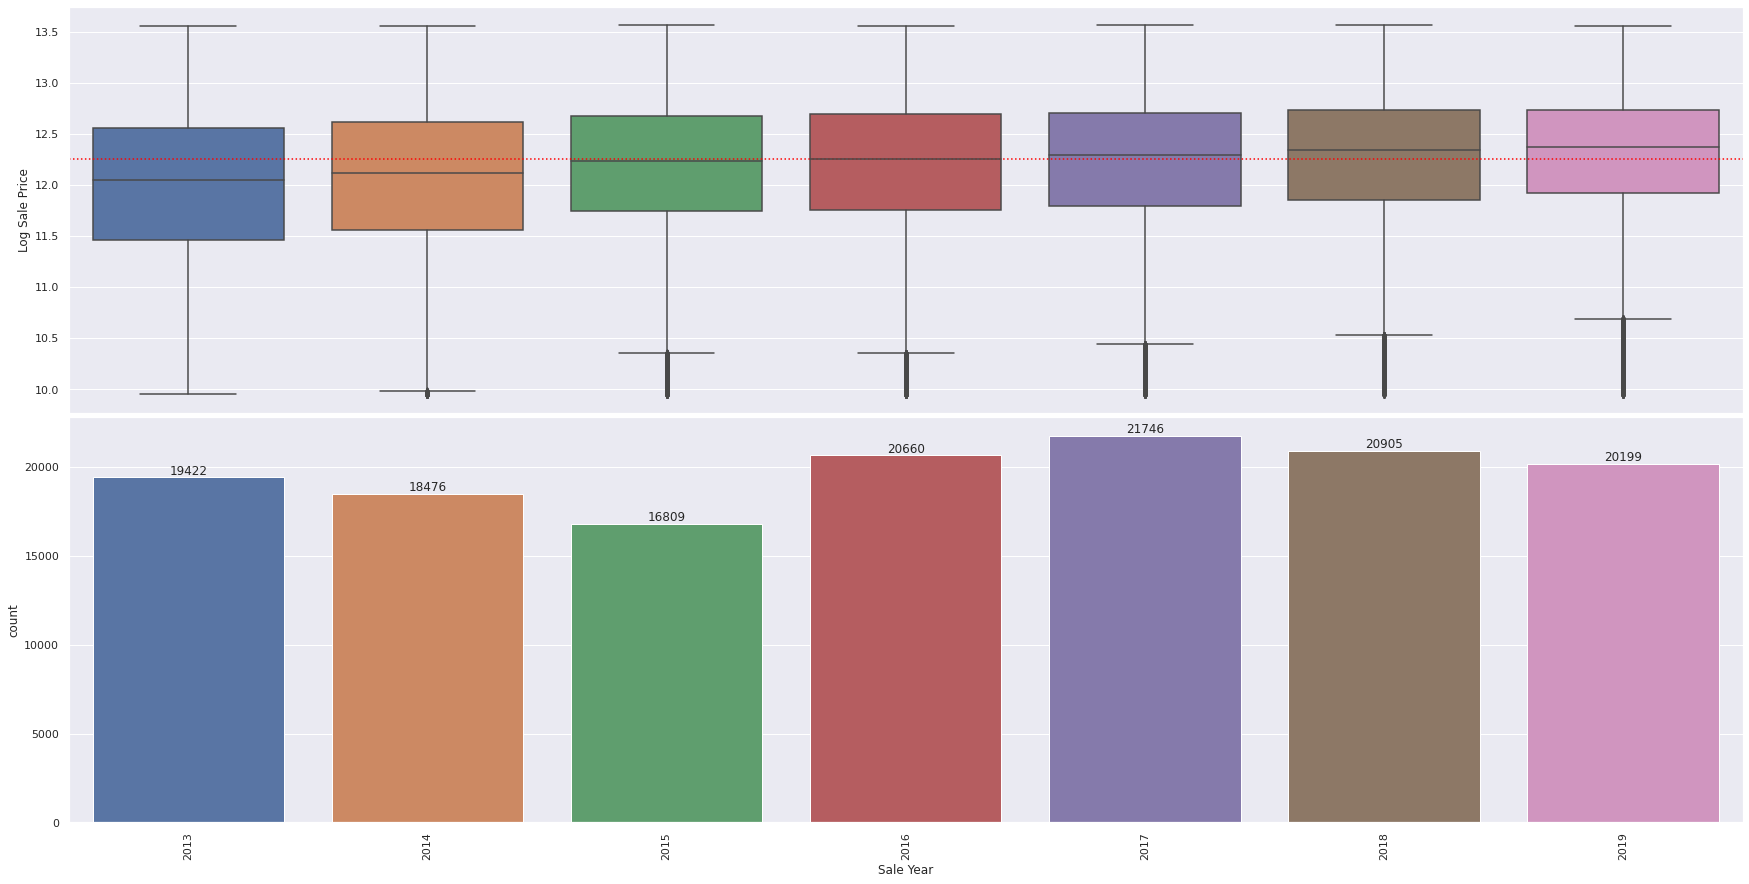

In [49]:
original_data = pd.read_csv('cook_county_contest_data/cook_county_contest_train.csv')
original_data['Log Sale Price'] = np.log(original_data['Sale Price'])
plot_categorical('Sale Year', original_data)